# Analysis of Graded Agent Responses

This notebook provides comprehensive visualization and analysis of agent response classifications generated by the `grade.py` script. It processes classification results stored in JSONL format and creates detailed visualizations comparing different agent configurations.

## What this notebook does:

### 1. **Data Loading & Processing**
- Automatically discovers and loads classification data from multiple result directories
- Handles both classified data (JSONL files) and raw response data (CSV files) as fallback
- Standardizes data formats across different experiment types

### 2. **Dataset Types Processed**
- **Single-agent results** (`results/`) - Individual model responses
- **Multi-agent results** (`results_multi/`) - Group conversation responses  
- **Multi-agent star topology** (`results_multi_star/`) - Star-pattern conversations
- **Additional experiments** - Any other `results_*` directories found automatically

### 3. **Visualizations Generated**
For each dataset type, the notebook creates:
- Distribution charts of rationale categories used by agents
- Off-topic response analysis (pie charts showing response relevance)
- Answer score distributions (histograms of numeric scores)
- Model-specific performance comparisons
- Cross-topology comparative analysis

### 4. **Advanced Analysis Features**
- Heatmaps showing rationale category usage patterns across topologies
- Statistical comparisons between different agent configurations
- Error analysis and data quality reporting
- Question category breakdowns (when available)

**Data Source Requirements**: The notebook expects classification files generated by `grade.py` to be present in the respective result directories. If classification data is missing, it will attempt to analyze raw CSV response files instead.

**Output**: Interactive Plotly charts, summary statistics tables, and comprehensive data quality reports.

In [21]:
import pandas as pd
import json
import os
import logging
import numpy as np
import glob
from pathlib import Path
import sys

# Add the current directory to sys.path to import analysis functions
sys.path.append(os.path.abspath('.'))

try:
    from analysis_functions import (
        load_datasets_with_fallback,
        prepare_datasets_for_analysis,
        create_combined_dataset,
        generate_summary_stats
    )
except ImportError as e:
    print(f"Error importing analysis functions: {e}")
    print("Make sure analysis_functions.py exists in the current directory")
    raise

# =============================================================================
# CONFIGURATION SECTION
# =============================================================================
# Base directory containing all result folders (results/, results_multi/, etc.)
BASE_DIR = "/Users/ram/Github/wisdom_agents/"

# =============================================================================
# LOGGING SETUP
# =============================================================================
# Configure logging to track data loading progress and any issues
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - NOTEBOOK - %(levelname)s - %(message)s')

# =============================================================================
# DATA LOADING PHASE
# =============================================================================
# Load datasets with automatic fallback from JSONL classification files to raw CSV files
print("=== LOADING DATASETS WITH FALLBACK TO RAW DATA ===")
datasets, dataset_info = load_datasets_with_fallback(BASE_DIR)

# =============================================================================
# DATA PREPARATION PHASE
# =============================================================================
# Standardize data formats and create analysis-ready dataframes
print("\n=== PREPARING DATA FOR ANALYSIS ===")
prepared_datasets = prepare_datasets_for_analysis(datasets, dataset_info)

# Create a combined dataset that merges all individual datasets for comparative analysis
print("\n=== CREATING COMBINED DATASET ===")
prepared_datasets['combined'] = create_combined_dataset(prepared_datasets)

# =============================================================================
# INITIAL DATA SUMMARY
# =============================================================================
# Display summary statistics for each dataset type to understand data availability
print("\n=== DATA PREPARATION SUMMARY ===")

for data_type, data_dict in prepared_datasets.items():
    # Extract the prepared dataframes for this dataset type
    analysis_df = data_dict['analysis']      # Main analysis dataframe with response data
    exploded_df = data_dict['exploded']      # Categories expanded (one row per category)
    errors_df = data_dict['errors']          # Processing errors encountered
    info = data_dict['info']                 # Metadata about the dataset
    
    print(f"\n{data_type.replace('_', '-').title()}:")
    print(f"  Valid responses: {len(analysis_df)}")
    print(f"  Exploded categories: {len(exploded_df)}")
    print(f"  Processing errors: {len(errors_df)}")
    print(f"  Has classification data: {'Yes' if info['has_classification'] else 'No'}")
    print(f"  File type: {info['file_type']}")
    
    if not analysis_df.empty:
        # Display additional metrics when data is available
        print(f"  Unique questions: {analysis_df['question_id'].nunique() if 'question_id' in analysis_df.columns else 'N/A'}")
        
        # Check for model column in various possible formats
        model_col = None
        for col in ['agent_model', 'model_name', 'agent_name']:
            if col in analysis_df.columns:
                model_col = col
                break
        
        if model_col:
            print(f"  Unique models: {analysis_df[model_col].nunique()}")
        
        # Report error types if any processing errors occurred
        if not errors_df.empty and 'error_type' in errors_df.columns:
            print(f"  Error types: {errors_df['error_type'].nunique()}")

=== LOADING DATASETS WITH FALLBACK TO RAW DATA ===

=== PREPARING DATA FOR ANALYSIS ===

=== CREATING COMBINED DATASET ===

=== DATA PREPARATION SUMMARY ===

Results-Ous-Multi:
  Valid responses: 0
  Exploded categories: 0
  Processing errors: 0
  Has classification data: No
  File type: unknown

Results-Multi-Star:
  Valid responses: 0
  Exploded categories: 0
  Processing errors: 0
  Has classification data: No
  File type: unknown

Results-Ous:
  Valid responses: 0
  Exploded categories: 0
  Processing errors: 0
  Has classification data: No
  File type: unknown

Results:
  Valid responses: 0
  Exploded categories: 0
  Processing errors: 0
  Has classification data: No
  File type: unknown

Results-Multi:
  Valid responses: 0
  Exploded categories: 0
  Processing errors: 0
  Has classification data: No
  File type: unknown

Combined:
  Valid responses: 0
  Exploded categories: 0
  Processing errors: 0
  Has classification data: No
  File type: combined

Results-Ous-Multi:
  Valid re

In [22]:
# =============================================================================
# SUMMARY STATISTICS TABLE GENERATION
# =============================================================================
# Generate a comprehensive summary table showing data availability across all datasets
summary_df = generate_summary_stats(prepared_datasets)

if not summary_df.empty:
    print("=== SUMMARY STATISTICS TABLE ===")
    print(summary_df.to_string(index=False))
    
    # =============================================================================
    # DATA AVAILABILITY ANALYSIS
    # =============================================================================
    # Categorize datasets by data quality and availability
    datasets_with_classification = summary_df[summary_df['Has Classification'] == 'Yes']
    datasets_with_raw_data = summary_df[summary_df['Has Classification'] == 'No']
    
    print(f"\n=== DATA AVAILABILITY SUMMARY ===")
    print(f"Datasets with classification data: {len(datasets_with_classification)}")
    if not datasets_with_classification.empty:
        print("  -", ", ".join(datasets_with_classification['Dataset'].tolist()))
    
    print(f"Datasets with raw data only: {len(datasets_with_raw_data)}")
    if not datasets_with_raw_data.empty:
        print("  -", ", ".join(datasets_with_raw_data['Dataset'].tolist()))
    
    # =============================================================================
    # PREPARE COMBINED DATASETS FOR VISUALIZATION
    # =============================================================================
    # Extract the combined dataframes that will be used for visualization
    df_all = prepared_datasets['combined']['analysis']          # All response data combined
    df_all_exploded = prepared_datasets['combined']['exploded']  # All categories exploded
    df_all_errors = prepared_datasets['combined']['errors']      # All processing errors
    
    print(f"\nCombined dataset: {len(df_all)} total records")
    print(f"Combined exploded categories: {len(df_all_exploded)} records")
    print(f"Combined errors: {len(df_all_errors)} records")
    
    # =============================================================================
    # COLUMN AVAILABILITY DEBUG INFO
    # =============================================================================
    # Display available columns for debugging and understanding data structure
    if not df_all.empty:
        print(f"\nAvailable columns in combined analysis data:")
        # Standard expected columns for basic analysis
        standard_cols = ['question_id', 'agent_name', 'agent_model', 'extracted_answer', 'extracted_answer_numeric', 'is_response_off_topic', 'selected_categories']
        available_standard = [col for col in df_all.columns if col in standard_cols]
        print(f"  Standard columns: {available_standard}")
        
        # Classification-specific columns
        classification_cols = [col for col in df_all.columns if 'classification' in col.lower() or col in ['off_topic_reason', 'error_type']]
        print(f"  Classification columns: {classification_cols}")
else:
    print("No data available for analysis")
    # Initialize empty dataframes if no data is available
    df_all = pd.DataFrame()
    df_all_exploded = pd.DataFrame()
    df_all_errors = pd.DataFrame()

=== SUMMARY STATISTICS TABLE ===
           Dataset Has Classification File Type  Responses  Exploded  Errors
 results_ous_multi                 No   unknown          0         0       0
results_multi_star                 No   unknown          0         0       0
       results_ous                 No   unknown          0         0       0
           results                 No   unknown          0         0       0
     results_multi                 No   unknown          0         0       0
          combined                 No  combined          0         0       0

=== DATA AVAILABILITY SUMMARY ===
Datasets with classification data: 0
Datasets with raw data only: 6
  - results_ous_multi, results_multi_star, results_ous, results, results_multi, combined

Combined dataset: 0 total records
Combined exploded categories: 0 records
Combined errors: 0 records


## Visualization of Graded Rationale Classifications

The following plots visualize the distribution of classified rationale categories, off-topic responses, answer scores, and other metrics. Visualizations are generated for each discovered dataset type:

1. **Single-agent results** - Individual model responses (from `results/`)
2. **Multi-agent results** - Group conversation responses (from `results_multi/`)
3. **Multi-agent star results** - Star topology conversations (from `results_multi_star/`)
4. **Other discovered datasets** - Any additional `results_*` directories
5. **Combined analysis** - Aggregate view across all types

**Note**: Some visualizations may not be available if classification data is missing. In such cases, basic statistics will be shown instead.

**Updated**: The visualization functions now handle standardized data formats and improved category processing.

## Visualization Section: Detailed Analysis Charts

This section generates comprehensive visualizations for each discovered dataset type. The charts provide insights into agent behavior patterns, response quality, and rationale classification distributions.

### Chart Types Generated:

#### 1. **Rationale Category Distribution Charts**
- **Purpose**: Shows which reasoning categories agents use most frequently
- **Data Source**: Exploded classification data with individual category instances
- **Chart Type**: Bar charts showing frequency counts for each rationale type

#### 2. **Off-Topic Response Analysis**
- **Purpose**: Identifies how often agents provide irrelevant or off-topic responses
- **Data Source**: Classification flags indicating response relevance
- **Chart Type**: Pie charts showing proportions of on-topic vs off-topic responses

#### 3. **Answer Score Distributions**
- **Purpose**: Analyzes the numeric quality scores assigned to agent responses
- **Data Source**: Extracted numeric scores from response evaluations
- **Chart Type**: Histograms showing the distribution of scores (typically 1-7 scale)

#### 4. **Model Performance Comparisons**
- **Purpose**: Compares how different AI models perform across rationale categories
- **Data Source**: Grouped data by agent model and category usage
- **Chart Type**: Grouped bar charts showing category usage by model type

#### 5. **Question-Specific Analysis**
- **Purpose**: Shows average performance across different question IDs
- **Data Source**: Aggregated scores grouped by individual questions
- **Chart Type**: Bar charts with average scores per question

### Dataset Coverage:
- **Single-agent**: Individual model responses without collaboration
- **Multi-agent**: Group conversations with multiple agents collaborating
- **Star topology**: Hub-and-spoke conversation patterns
- **Combined analysis**: Aggregate view across all experiment types

**Note**: If classification data is unavailable, the notebook displays informative messages and attempts analysis using available raw data.

**Interactivity**: All charts are generated using Plotly for interactive exploration (zoom, hover details, etc.)

In [23]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# Set theme for seaborn plots to ensure consistent styling
sns.set_theme(style="whitegrid")

# =============================================================================
# VISUALIZATION FUNCTION DEFINITIONS
# =============================================================================
# These functions create standardized charts for different aspects of the data

def plot_category_distribution(df_exploded, title_prefix=""):
    """
    Create a bar chart showing the frequency of each rationale category.
    
    Args:
        df_exploded: DataFrame with one row per category instance
        title_prefix: String to prepend to chart title (e.g., "Single-Agent -")
    
    Returns:
        Plotly figure object or None if no data available
    """
    if df_exploded.empty or 'selected_categories' not in df_exploded.columns:
        print(f"No data available for category distribution: {title_prefix}")
        return None
    
    # Filter to only valid (non-null) categories
    valid_categories = df_exploded[df_exploded['selected_categories'].notna()]
    if valid_categories.empty:
        print(f"No valid categories found: {title_prefix}")
        return None
    
    # Count frequency of each category and prepare for plotting
    category_counts = valid_categories['selected_categories'].value_counts().reset_index()
    category_counts.columns = ['category', 'count']
    
    # Create interactive bar chart
    fig = px.bar(category_counts, x='category', y='count',
                 title=f'{title_prefix} Distribution of Selected Rationale Categories',
                 labels={'category': 'Rationale Category', 'count': 'Frequency'},
                 height=600)
    fig.update_layout(xaxis_tickangle=-45)  # Rotate labels for readability
    return fig

def plot_off_topic_distribution(df_analysis, title_prefix=""):
    """
    Create a pie chart showing the proportion of on-topic vs off-topic responses.
    
    Args:
        df_analysis: Main analysis DataFrame with off-topic flags
        title_prefix: String to prepend to chart title
    
    Returns:
        Plotly figure object or None if no data available
    """
    if df_analysis.empty or 'is_response_off_topic' not in df_analysis.columns:
        print(f"No off-topic data available: {title_prefix}")
        return None
    
    # Count on-topic vs off-topic responses (including null values)
    off_topic_counts = df_analysis['is_response_off_topic'].value_counts(dropna=False).reset_index()
    off_topic_counts.columns = ['is_off_topic', 'count']
    
    # Create interactive pie chart with hole in center (donut chart)
    fig = px.pie(off_topic_counts, names='is_off_topic', values='count',
                 title=f'{title_prefix} Distribution of Off-Topic Responses',
                 hole=0.3)
    return fig

def plot_answer_distribution(df_analysis, title_prefix=""):
    """
    Create a histogram showing the distribution of numeric answer scores.
    
    Args:
        df_analysis: Main analysis DataFrame with numeric scores
        title_prefix: String to prepend to chart title
    
    Returns:
        Plotly figure object or None if no data available
    """
    if df_analysis.empty or 'extracted_answer_numeric' not in df_analysis.columns:
        print(f"No answer score data available: {title_prefix}")
        return None
    
    # Filter to only valid (non-null) numeric answers
    valid_answers = df_analysis[df_analysis['extracted_answer_numeric'].notna()]
    if valid_answers.empty:
        print(f"No valid answer scores found: {title_prefix}")
        return None
    
    # Create histogram with 7 bins (typically for 1-7 rating scale)
    fig = px.histogram(valid_answers, x='extracted_answer_numeric',
                       title=f'{title_prefix} Distribution of Answer Scores',
                       labels={'extracted_answer_numeric': 'Answer Score'},
                       nbins=7)
    return fig

def plot_categories_by_model(df_exploded, title_prefix=""):
    """
    Create a grouped bar chart comparing category usage across different AI models.
    
    Args:
        df_exploded: DataFrame with exploded categories and model information
        title_prefix: String to prepend to chart title
    
    Returns:
        Plotly figure object or None if no data available
    """
    if (df_exploded.empty or 'agent_model' not in df_exploded.columns or 
        'selected_categories' not in df_exploded.columns):
        print(f"No model/category data available: {title_prefix}")
        return None
    
    # Filter to valid data only
    valid_data = df_exploded[df_exploded['selected_categories'].notna()]
    if valid_data.empty:
        print(f"No valid model/category data found: {title_prefix}")
        return None
    
    # Group by model and category to get counts
    categories_by_model = valid_data.groupby(['agent_model', 'selected_categories']).size().reset_index(name='count')
    
    if categories_by_model.empty:
        print(f"No aggregated model/category data: {title_prefix}")
        return None
    
    # Create grouped bar chart with different colors for each model
    fig = px.bar(categories_by_model, x='selected_categories', y='count',
                 color='agent_model', barmode='group',
                 title=f'{title_prefix} Rationale Categories by Agent Model',
                 labels={'selected_categories': 'Rationale Category', 'count': 'Frequency'},
                 height=700)
    fig.update_layout(xaxis_tickangle=-45)  # Rotate labels for readability
    return fig

# =============================================================================
# GENERATE VISUALIZATIONS FOR EACH DATASET TYPE
# =============================================================================
# Create comprehensive visualizations for each discovered dataset

for data_type, data_dict in prepared_datasets.items():
    # Extract dataframes for this dataset type
    analysis_df = data_dict['analysis']
    exploded_df = data_dict['exploded']
    
    # Skip if no data is available for this dataset type
    if analysis_df.empty:
        print(f"\n=== {data_type.replace('_', ' ').upper()} VISUALIZATIONS ===")
        print(f"No data available for {data_type} visualizations")
        continue
    
    # Format dataset name for display
    dataset_name = data_type.replace('_', '-').title()
    print(f"\n=== {dataset_name.upper()} VISUALIZATIONS ===")
    
    # Generate visualization 1: Distribution of rationale categories
    fig = plot_category_distribution(exploded_df, f"{dataset_name} -")
    if fig:
        fig.show()
    
    # Generate visualization 2: Proportion of off-topic responses
    fig = plot_off_topic_distribution(analysis_df, f"{dataset_name} -")
    if fig:
        fig.show()
    
    # Generate visualization 3: Distribution of answer quality scores
    fig = plot_answer_distribution(analysis_df, f"{dataset_name} -")
    if fig:
        fig.show()
    
    # Generate visualization 4: Category usage comparison across models
    fig = plot_categories_by_model(exploded_df, f"{dataset_name} -")
    if fig:
        fig.show()
    
    # Generate visualization 5: Average answer scores by individual questions
    if ('extracted_answer_numeric' in analysis_df.columns and 
        'question_id' in analysis_df.columns and
        analysis_df['extracted_answer_numeric'].notna().any()):
        
        # Calculate average score for each question
        avg_answer_by_qid = analysis_df.groupby('question_id')['extracted_answer_numeric'].mean().reset_index()
        if not avg_answer_by_qid.empty:
            fig = px.bar(avg_answer_by_qid, x='question_id', y='extracted_answer_numeric',
                        title=f'{dataset_name} - Average Answer Score by Question ID',
                        labels={'question_id': 'Question ID', 'extracted_answer_numeric': 'Average Answer Score'})
            fig.update_layout(xaxis_type='category')  # Treat question IDs as categories
            fig.show()


=== RESULTS OUS MULTI VISUALIZATIONS ===
No data available for results_ous_multi visualizations

=== RESULTS MULTI STAR VISUALIZATIONS ===
No data available for results_multi_star visualizations

=== RESULTS OUS VISUALIZATIONS ===
No data available for results_ous visualizations

=== RESULTS VISUALIZATIONS ===
No data available for results visualizations

=== RESULTS MULTI VISUALIZATIONS ===
No data available for results_multi visualizations

=== COMBINED VISUALIZATIONS ===
No data available for combined visualizations


In [24]:
# =============================================================================
# COMPARATIVE ANALYSIS BETWEEN DATASET TYPES
# =============================================================================
# This section creates side-by-side comparisons between different experiment types
# (single-agent vs multi-agent vs star topology, etc.)

print("\n=== COMPARATIVE ANALYSIS ===")

# Filter out the 'combined' dataset for comparison (we'll show it separately)
# We want to compare individual dataset types, not the combined aggregation
comparison_datasets = {k: v for k, v in prepared_datasets.items() if k != 'combined'}

if len(comparison_datasets) >= 2:
    print(f"Comparing {len(comparison_datasets)} dataset types")
    
    # =============================================================================
    # COMPARISON 1: SIDE-BY-SIDE CATEGORY DISTRIBUTION
    # =============================================================================
    # Create subplots showing category distributions for each dataset type
    
    # Filter to datasets that have valid exploded category data
    valid_exploded_datasets = {k: v['exploded'] for k, v in comparison_datasets.items() 
                              if not v['exploded'].empty and 'selected_categories' in v['exploded'].columns}
    
    if len(valid_exploded_datasets) >= 2:
        print("\n1. Category Distribution Comparison")
        
        # Calculate grid layout for subplots (max 3 columns)
        n_datasets = len(valid_exploded_datasets)
        cols = min(3, n_datasets)  # Maximum 3 columns for readability
        rows = (n_datasets + cols - 1) // cols  # Calculate needed rows
        
        # Create subplot grid with individual bar charts
        fig = make_subplots(
            rows=rows, cols=cols,
            subplot_titles=[k.replace('_', '-').title() for k in valid_exploded_datasets.keys()],
            specs=[[{"type": "bar"} for _ in range(cols)] for _ in range(rows)]
        )
        
        # Add data for each dataset type to its subplot
        for i, (data_type, exploded_df) in enumerate(valid_exploded_datasets.items()):
            row = (i // cols) + 1
            col = (i % cols) + 1
            
            # Get top 10 categories for this dataset (to avoid overcrowding)
            category_counts = exploded_df['selected_categories'].value_counts().head(10)
            
            fig.add_trace(
                go.Bar(x=category_counts.index, y=category_counts.values, 
                      name=data_type.replace('_', '-').title()),
                row=row, col=col
            )
        
        # Update layout and display
        fig.update_layout(
            title_text="Top 10 Rationale Categories by Dataset Type",
            height=400 * rows,
            showlegend=False  # Hide legend since subplot titles show dataset names
        )
        fig.update_xaxes(tickangle=-45)  # Rotate x-axis labels
        fig.show()
    
    # =============================================================================
    # COMPARISON 2: ANSWER SCORE DISTRIBUTION COMPARISON
    # =============================================================================
    # Create box plots comparing answer score distributions across dataset types
    
    valid_analysis_datasets = {k: v['analysis'] for k, v in comparison_datasets.items() 
                              if not v['analysis'].empty and 'extracted_answer_numeric' in v['analysis'].columns}
    
    if len(valid_analysis_datasets) >= 2:
        print("\n2. Answer Score Distribution Comparison")
        
        # Combine data from all datasets for comparison
        comparison_data = []
        for data_type, analysis_df in valid_analysis_datasets.items():
            scores = analysis_df[analysis_df['extracted_answer_numeric'].notna()]
            for score in scores['extracted_answer_numeric']:
                comparison_data.append({
                    'score': score, 
                    'dataset_type': data_type.replace('_', '-').title()
                })
        
        if comparison_data:
            comparison_df = pd.DataFrame(comparison_data)
            
            # Create box plot showing distribution differences
            fig = px.box(comparison_df, x='dataset_type', y='score',
                        title='Answer Score Distribution by Dataset Type',
                        labels={'dataset_type': 'Dataset Type', 'score': 'Answer Score'})
            fig.show()
    
    # =============================================================================
    # COMPARISON 3: OFF-TOPIC RESPONSE RATE COMPARISON
    # =============================================================================
    # Calculate and compare the percentage of off-topic responses across dataset types
    
    print("\n3. Off-topic Response Rate Comparison")
    
    off_topic_comparison_data = []
    for data_type, data_dict in comparison_datasets.items():
        analysis_df = data_dict['analysis']
        if not analysis_df.empty and 'is_response_off_topic' in analysis_df.columns:
            # Calculate percentage of off-topic responses
            off_topic_rate = (analysis_df['is_response_off_topic'].sum() / len(analysis_df)) * 100
            off_topic_comparison_data.append({
                'dataset_type': data_type.replace('_', '-').title(),
                'off_topic_rate': off_topic_rate,
                'total_responses': len(analysis_df)
            })
    
    if off_topic_comparison_data:
        off_topic_df = pd.DataFrame(off_topic_comparison_data)
        
        # Create bar chart with response counts as text labels
        fig = px.bar(off_topic_df, x='dataset_type', y='off_topic_rate',
                    title='Off-Topic Response Rates by Dataset Type (%)',
                    labels={'dataset_type': 'Dataset Type', 'off_topic_rate': 'Off-Topic Rate (%)'},
                    text='total_responses'  # Show sample size on bars
                   )
        fig.update_traces(texttemplate='n=%{text}', textposition="outside")
        fig.show()
    
    # =============================================================================
    # COMPARISON 4: MODEL PERFORMANCE ACROSS DATASET TYPES
    # =============================================================================
    # Compare how the same models perform in different experimental setups
    
    print("\n4. Model Performance Comparison")
    
    model_performance_data = []
    for data_type, data_dict in comparison_datasets.items():
        analysis_df = data_dict['analysis']
        if (not analysis_df.empty and 'agent_model' in analysis_df.columns and 
            'extracted_answer_numeric' in analysis_df.columns):
            
            # Calculate average performance per model for this dataset
            model_perf = analysis_df.groupby('agent_model')['extracted_answer_numeric'].agg(['mean', 'count']).reset_index()
            model_perf['dataset_type'] = data_type.replace('_', '-').title()
            model_performance_data.append(model_perf)
    
    if model_performance_data:
        combined_model_perf = pd.concat(model_performance_data, ignore_index=True)
        
        # Filter to models that appear in multiple datasets (for meaningful comparison)
        model_counts = combined_model_perf['agent_model'].value_counts()
        common_models = model_counts[model_counts > 1].index
        
        if len(common_models) > 0:
            filtered_perf = combined_model_perf[combined_model_perf['agent_model'].isin(common_models)]
            
            # Create grouped bar chart with sample sizes as text
            fig = px.bar(filtered_perf, x='agent_model', y='mean',
                        color='dataset_type', barmode='group',
                        title='Average Answer Score by Model and Dataset Type',
                        labels={'agent_model': 'Agent Model', 'mean': 'Average Answer Score'},
                        text='count')  # Show sample size for each bar
            fig.update_traces(texttemplate='n=%{text}', textposition="outside")
            fig.update_layout(xaxis_tickangle=-45)
            fig.show()

else:
    print("Not enough datasets for comparative analysis (need at least 2 non-empty datasets)")

print("\n=== ANALYSIS COMPLETE ===")


=== COMPARATIVE ANALYSIS ===
Comparing 5 dataset types

3. Off-topic Response Rate Comparison

4. Model Performance Comparison

=== ANALYSIS COMPLETE ===


In [25]:
# =============================================================================
# COMPREHENSIVE SUMMARY STATISTICS TABLE
# =============================================================================
# Generate and display a final summary table with all key metrics

print("=== COMPREHENSIVE SUMMARY STATISTICS ===")

summary_df = generate_summary_stats(prepared_datasets)

if not summary_df.empty:
    print("\nDetailed Summary Statistics:")
    print(summary_df.to_string(index=False))
    
    # Create an interactive table using Plotly if available
    try:
        import plotly.graph_objects as go
        
        fig = go.Figure(data=[go.Table(
            header=dict(values=list(summary_df.columns),
                       fill_color='paleturquoise',
                       align='left'),
            cells=dict(values=[summary_df[col] for col in summary_df.columns],
                      fill_color='lavender',
                      align='left'))
        ])
        fig.update_layout(title="Summary Statistics: Multi-Dataset Analysis with Improved Data Handling")
        fig.show()
    except ImportError:
        print("Plotly not available, summary table shown above")

# =============================================================================
# ERROR ANALYSIS SECTION
# =============================================================================
# Analyze and visualize any processing errors encountered during data loading

# Combine errors from all datasets for comprehensive error analysis
all_errors = []
for data_type, data_dict in prepared_datasets.items():
    errors_df = data_dict['errors']
    if not errors_df.empty:
        errors_df = errors_df.copy()
        errors_df['source_dataset'] = data_type.replace('_', '-').title()
        all_errors.append(errors_df)

if all_errors:
    combined_errors = pd.concat(all_errors, ignore_index=True)
    
    print("\n=== ERROR ANALYSIS ===")
    if 'error_type' in combined_errors.columns:
        # Group errors by type and source dataset
        error_by_type = combined_errors.groupby(['source_dataset', 'error_type']).size().reset_index(name='count')
        
        if not error_by_type.empty:
            # Create visualization of error patterns
            try:
                import plotly.express as px
                fig = px.bar(error_by_type, x='error_type', y='count', color='source_dataset',
                            title='Processing Errors by Type and Dataset',
                            labels={'error_type': 'Error Type', 'count': 'Count'},
                            barmode='group')
                fig.update_layout(xaxis_tickangle=-45)
                fig.show()
            except ImportError:
                print("Plotly not available for error visualization")
            
            # Create a summary table of errors
            print("Error summary by dataset:")
            try:
                error_pivot = error_by_type.pivot(index='error_type', columns='source_dataset', values='count').fillna(0)
                print(error_pivot)
            except Exception as e:
                print(f"Could not create error pivot table: {e}")
                print(error_by_type)
else:
    print("\n=== NO PROCESSING ERRORS FOUND ===")

# =============================================================================
# DATA QUALITY REPORT
# =============================================================================
# Provide a comprehensive report on data quality and completeness

print("\n=== DATA QUALITY REPORT ===")
for data_type, data_dict in prepared_datasets.items():
    if data_type != 'combined':  # Skip the combined dataset in individual reports
        info = data_dict['info']
        analysis_df = data_dict['analysis']
        exploded_df = data_dict['exploded']
        
        # Determine data availability status with visual indicators
        if info['has_classification']:
            status = "✓ Classification data"  # Full classification data available
        elif not analysis_df.empty:
            status = "○ Raw data only"        # Only raw response data available
        else:
            status = "✗ No data"              # No usable data found
            
        print(f"\n{data_type}:")
        print(f"  Status: {status}")
        print(f"  Files processed: {info['file_count']}")
        print(f"  File type: {info['file_type']}")
        
        if not analysis_df.empty:
            # Assess data completeness for key columns
            key_columns = ['question_id', 'agent_name', 'extracted_answer']
            missing_data = {}
            for col in key_columns:
                if col in analysis_df.columns:
                    missing_count = analysis_df[col].isna().sum()
                    missing_pct = (missing_count / len(analysis_df)) * 100
                    missing_data[col] = f"{missing_count} ({missing_pct:.1f}%)"
                else:
                    missing_data[col] = "Column missing"
            
            print(f"  Missing data: {missing_data}")
            
            # Calculate category richness if classification data is available
            if info['has_classification'] and not exploded_df.empty:
                avg_categories = len(exploded_df) / len(analysis_df)
                print(f"  Categories per response: {avg_categories:.1f} avg")

# =============================================================================
# FINAL EXECUTION SUMMARY
# =============================================================================
# Provide a final summary of what was processed and analyzed

print("\nNotebook execution complete!")
print("\nData Sources Summary:")
for data_type, data_dict in prepared_datasets.items():
    if data_type != 'combined':
        info = data_dict['info']
        analysis_df = data_dict['analysis']
        
        # Status indicators for quick reference
        if info['has_classification']:
            status = "✓ Classification data"
        elif not analysis_df.empty:
            status = "○ Raw data only"
        else:
            status = "✗ No data"
            
        print(f"  {data_type}: {status} ({info['file_count']} files)")

=== COMPREHENSIVE SUMMARY STATISTICS ===

Detailed Summary Statistics:
           Dataset Has Classification File Type  Responses  Exploded  Errors
 results_ous_multi                 No   unknown          0         0       0
results_multi_star                 No   unknown          0         0       0
       results_ous                 No   unknown          0         0       0
           results                 No   unknown          0         0       0
     results_multi                 No   unknown          0         0       0
          combined                 No  combined          0         0       0



=== NO PROCESSING ERRORS FOUND ===

=== DATA QUALITY REPORT ===

results_ous_multi:
  Status: ✗ No data
  Files processed: 38
  File type: unknown

results_multi_star:
  Status: ✗ No data
  Files processed: 3
  File type: unknown

results_ous:
  Status: ✗ No data
  Files processed: 12
  File type: unknown

results:
  Status: ✗ No data
  Files processed: 15
  File type: unknown

results_multi:
  Status: ✗ No data
  Files processed: 14
  File type: unknown

Notebook execution complete!

Data Sources Summary:
  results_ous_multi: ✗ No data (38 files)
  results_multi_star: ✗ No data (3 files)
  results_ous: ✗ No data (12 files)
  results: ✗ No data (15 files)
  results_multi: ✗ No data (14 files)


In [26]:
# =============================================================================
# COMPREHENSIVE RATIONALE CLASSIFICATION ANALYSIS
# =============================================================================
# Advanced analysis focusing specifically on rationale categories across different
# agent topologies and question categories

import glob, os, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from grade import RATIONALE_CATEGORIES

# Extract the list of valid/approved rationale category names
# This ensures we only analyze legitimate categories defined in the grading system
valid_cats = [c["name"] for c in RATIONALE_CATEGORIES]

# =============================================================================
# TOPOLOGY-SPECIFIC DATA LOADING
# =============================================================================
# Map human-readable topology names to their corresponding result directories
# This allows us to compare different agent interaction patterns

topologies = {
    "Single-Agent": os.path.join(BASE_DIR, "results"),         # Individual agent responses
    "Multi-Agent": os.path.join(BASE_DIR, "results_multi"),    # Group conversations
    "Star-Topology": os.path.join(BASE_DIR, "results_multi_star")  # Hub-and-spoke patterns
}

# =============================================================================
# CLASSIFICATION DATA COLLECTION
# =============================================================================
# Collect all classification data across topologies with category information

all_classification_data = []
for topo_name, dir_path in topologies.items():
    # Look for classification files (JSONL format) in each topology directory
    for fpath in glob.glob(os.path.join(dir_path, "*_classification.jsonl")):
        dfj = pd.read_json(fpath, lines=True)
        if "selected_categories" in dfj.columns:
            # Add topology information to each record for later analysis
            dfj['topology'] = topo_name
            all_classification_data.append(dfj)

# =============================================================================
# DATA PREPARATION FOR ANALYSIS
# =============================================================================
# Combine and prepare data for comprehensive analysis

if all_classification_data:
    # Combine all classification data into a single dataframe
    combined_df = pd.concat(all_classification_data, ignore_index=True)
    
    # Explode the categories column to get one row per category instance
    # This is essential for counting individual category usage
    exploded_df = combined_df.explode("selected_categories")
    
    # Filter to only include valid/approved categories to ensure data quality
    exploded_df = exploded_df[exploded_df['selected_categories'].isin(valid_cats)]
    
    # Extract unique question categories for potential sub-analysis
    question_categories = sorted(exploded_df['category'].dropna().unique()) if 'category' in exploded_df.columns else ['All Questions']
    
    # =============================================================================
    # DATA SUMMARY OUTPUT
    # =============================================================================
    print(f"Found {len(question_categories)} question categories: {question_categories}")
    print(f"Found {len(topologies)} topologies: {list(topologies.keys())}")
    print(f"Total classification records: {len(combined_df)}")
    print(f"Valid rationale categories found: {len(exploded_df['selected_categories'].unique())}")
else:
    # Handle case where no classification data is available
    exploded_df = pd.DataFrame()
    question_categories = []
    print("No classification data found.")

Found 1 question categories: ['All Questions']
Found 3 topologies: ['Single-Agent', 'Multi-Agent', 'Star-Topology']
Total classification records: 447374
Valid rationale categories found: 26


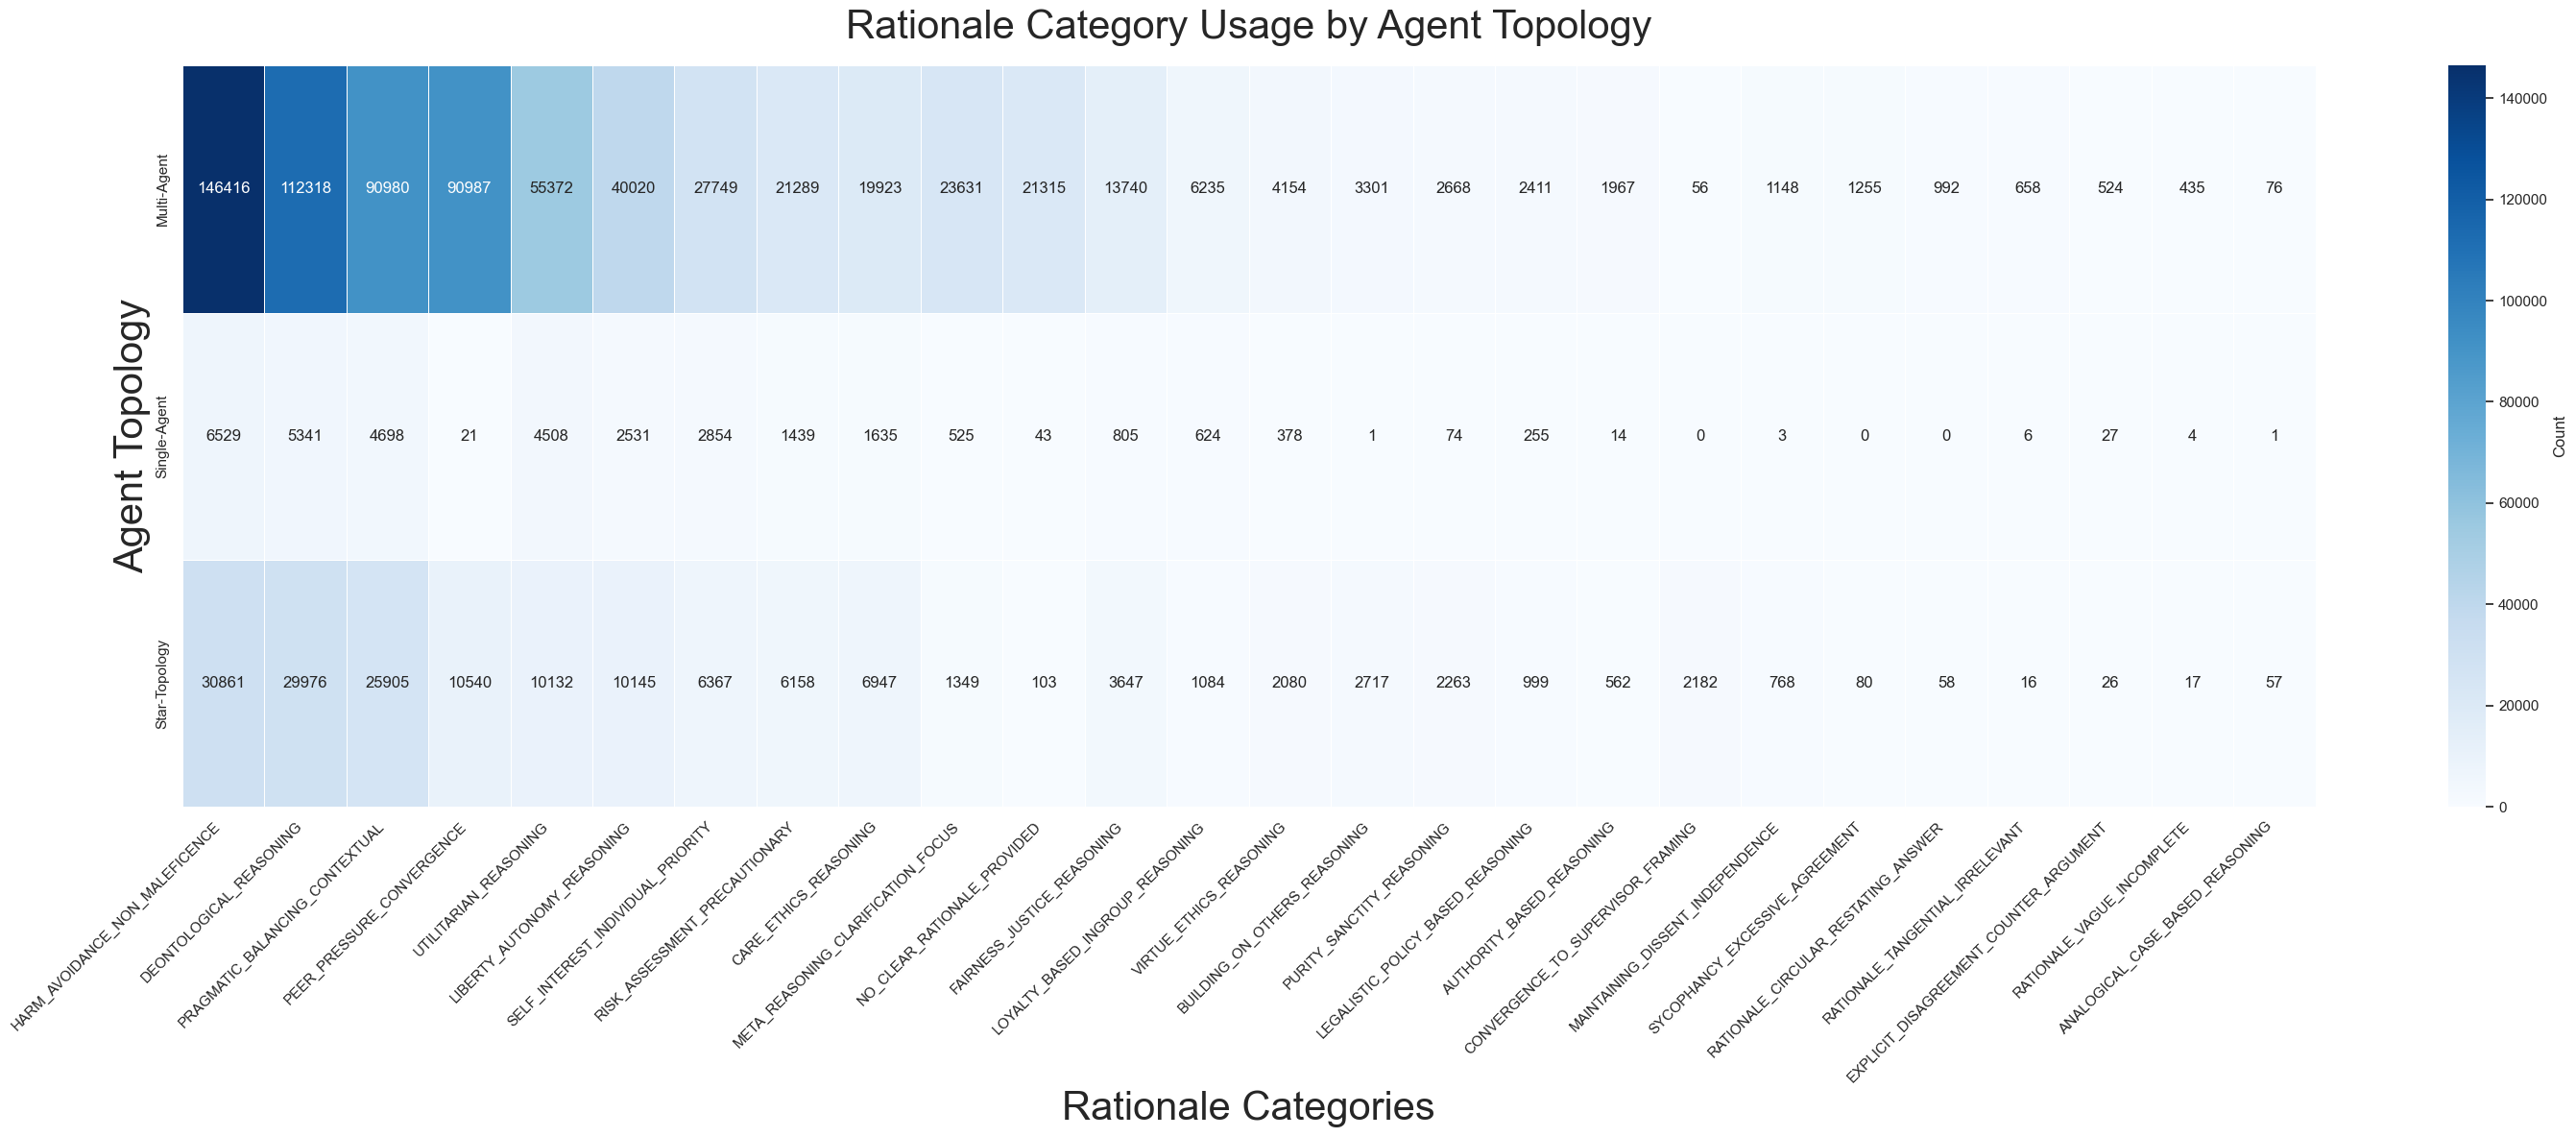


=== TOPOLOGY COMPARISON SUMMARY ===

Multi-Agent:
  Total category instances: 689620
  Top 3 categories: HARM_AVOIDANCE_NON_MALEFICENCE (146416), DEONTOLOGICAL_REASONING (112318), PEER_PRESSURE_CONVERGENCE (90987)

Single-Agent:
  Total category instances: 32316
  Top 3 categories: HARM_AVOIDANCE_NON_MALEFICENCE (6529), DEONTOLOGICAL_REASONING (5341), PRAGMATIC_BALANCING_CONTEXTUAL (4698)

Star-Topology:
  Total category instances: 155039
  Top 3 categories: HARM_AVOIDANCE_NON_MALEFICENCE (30861), DEONTOLOGICAL_REASONING (29976), PRAGMATIC_BALANCING_CONTEXTUAL (25905)


In [27]:
# =============================================================================
# OVERVIEW HEATMAP: ALL TOPOLOGIES AND CATEGORIES
# =============================================================================
# Create a comprehensive heatmap showing rationale category usage patterns
# across all agent topologies in a single visualization

if not exploded_df.empty:
    # =============================================================================
    # DATA AGGREGATION FOR HEATMAP
    # =============================================================================
    # Group data by topology and category to get usage counts
    topology_category_counts = exploded_df.groupby(['topology', 'selected_categories']).size().reset_index(name='count')
    
    # Create a pivot table suitable for heatmap visualization
    # Rows = topologies, Columns = rationale categories, Values = usage counts
    heatmap_data = topology_category_counts.pivot(
        index='topology', 
        columns='selected_categories', 
        values='count'
    ).fillna(0)  # Fill missing combinations with 0
    
    # =============================================================================
    # COLUMN ORDERING FOR BETTER VISUALIZATION
    # =============================================================================
    # Order columns by overall frequency to highlight most important categories
    col_order = exploded_df['selected_categories'].value_counts().index
    heatmap_data = heatmap_data[col_order]
    
    # =============================================================================
    # HEATMAP VISUALIZATION
    # =============================================================================
    # Create a large, detailed heatmap with annotations
    plt.figure(figsize=(30, 12))
    sns.heatmap(heatmap_data, 
                annot=True,              # Show count values in each cell
                fmt='g',                 # Format numbers without decimals
                cmap='Blues',            # Blue color scheme (light to dark)
                cbar_kws={'label': 'Count'},  # Label for color bar
                linewidths=0.5)          # Add grid lines between cells
    
    # Customize the plot appearance
    plt.title('Rationale Category Usage by Agent Topology', fontsize=30, pad=20)
    plt.xlabel('Rationale Categories', fontsize=30)
    plt.ylabel('Agent Topology', fontsize=30)
    plt.xticks(rotation=45, ha='right')  # Rotate category labels for readability
    plt.tight_layout()  # Adjust spacing to prevent label cutoff
    plt.show()
    
    # =============================================================================
    # SUMMARY STATISTICS BY TOPOLOGY
    # =============================================================================
    # Provide quantitative summary of topology differences
    print("\n=== TOPOLOGY COMPARISON SUMMARY ===")
    for topology in heatmap_data.index:
        # Calculate total category instances for this topology
        total_categories = heatmap_data.loc[topology].sum()
        
        # Find the top 3 most used categories for this topology
        top_3_categories = heatmap_data.loc[topology].nlargest(3)
        
        print(f"\n{topology}:")
        print(f"  Total category instances: {int(total_categories)}")
        print(f"  Top 3 categories: {', '.join([f'{cat} ({int(count)})' for cat, count in top_3_categories.items()])}")
else:
    print("No data available for topology comparison heatmap.")

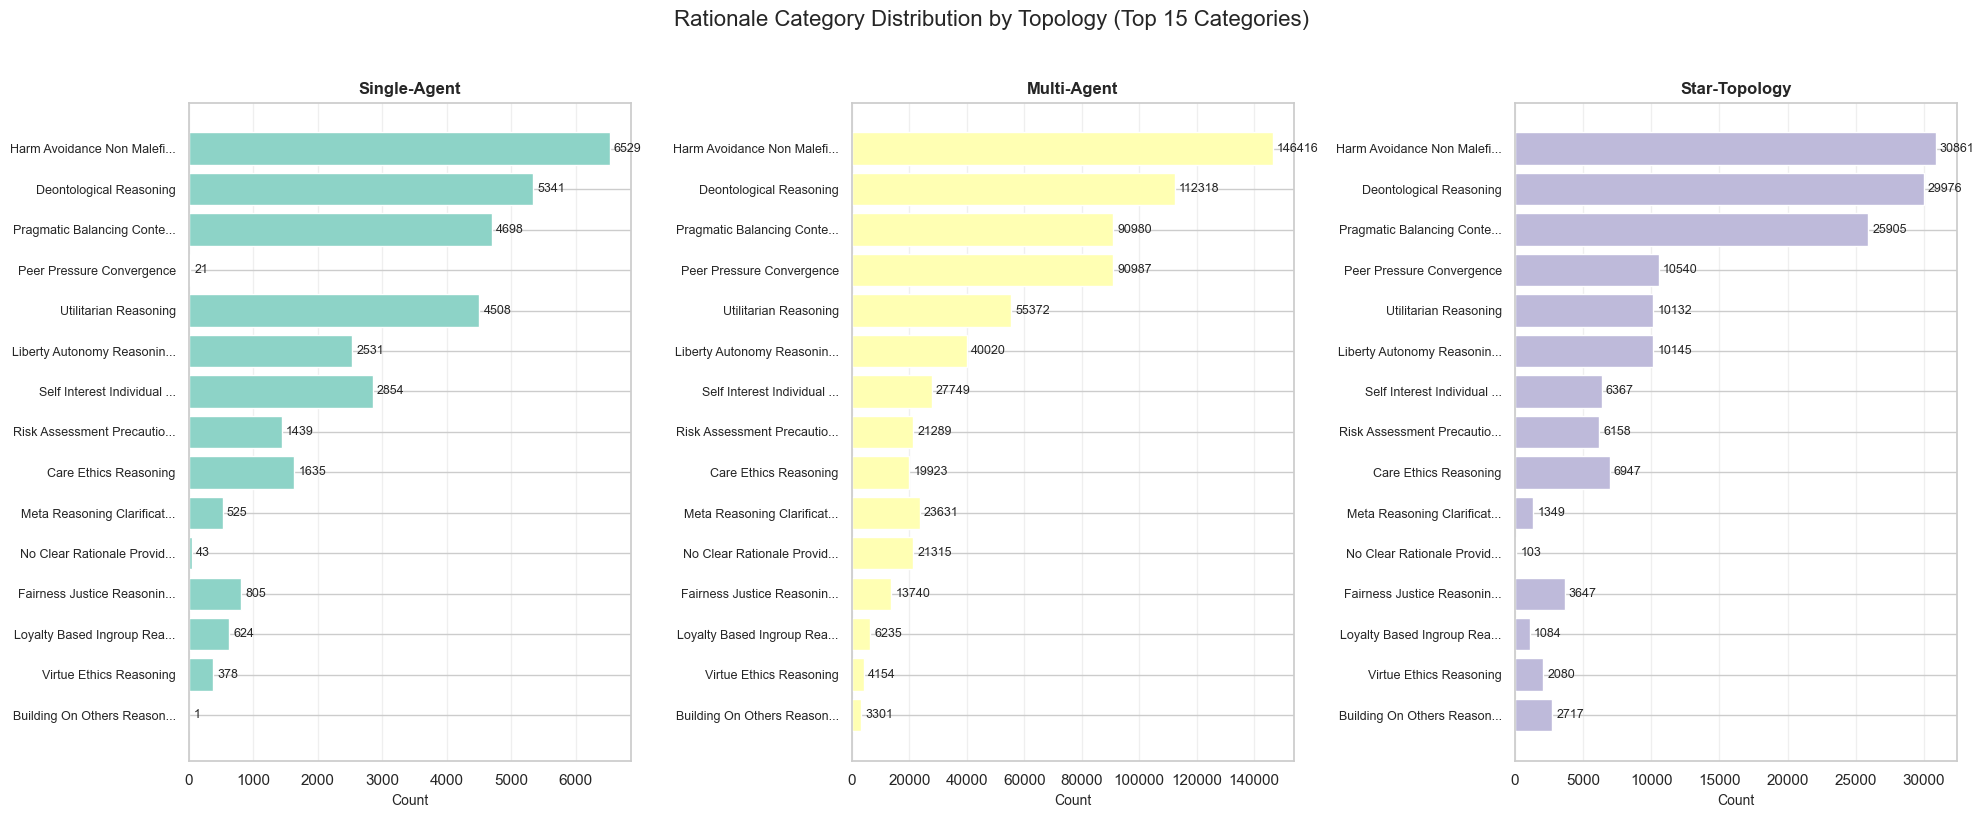

In [28]:
# =============================================================================
# INDIVIDUAL TOPOLOGY ANALYSIS: FOCUSED COMPARISON CHARTS
# =============================================================================
# Create separate detailed charts for each topology to enable direct comparison
# of the top rationale categories across different agent interaction patterns

if not exploded_df.empty:
    # =============================================================================
    # CATEGORY SELECTION FOR CONSISTENT COMPARISON
    # =============================================================================
    # Get the top 15 most frequent categories across ALL topologies
    # This ensures we compare the same categories across all topologies
    top_categories = exploded_df['selected_categories'].value_counts().head(15).index.tolist()
    
    # =============================================================================
    # SUBPLOT LAYOUT SETUP
    # =============================================================================
    # Create a figure with 3 subplots (one for each topology)
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    fig.suptitle('Rationale Category Distribution by Topology (Top 15 Categories)', fontsize=16, y=1.02)
    
    # =============================================================================
    # GENERATE INDIVIDUAL TOPOLOGY CHARTS
    # =============================================================================
    for idx, (topo_name, ax) in enumerate(zip(topologies.keys(), axes)):
        # Filter data for this specific topology
        topo_data = exploded_df[exploded_df['topology'] == topo_name]
        
        if not topo_data.empty:
            # =============================================================================
            # DATA PREPARATION FOR THIS TOPOLOGY
            # =============================================================================
            # Count category usage and ensure all top categories are represented
            category_counts = topo_data['selected_categories'].value_counts()
            category_counts = category_counts.reindex(top_categories, fill_value=0)
            
            # =============================================================================
            # HORIZONTAL BAR CHART CREATION
            # =============================================================================
            # Create horizontal bar chart for better label readability
            y_pos = range(len(category_counts))
            bars = ax.barh(y_pos, category_counts.values, color=plt.cm.Set3(idx))
            
            # =============================================================================
            # VALUE LABELS ON BARS
            # =============================================================================
            # Add count values as text labels on each bar
            max_count = max(category_counts.values) if len(category_counts.values) > 0 else 1
            for i, (bar, count) in enumerate(zip(bars, category_counts.values)):
                if count > 0:  # Only show labels for non-zero bars
                    ax.text(bar.get_width() + max_count * 0.01,  # Position slightly right of bar end
                           bar.get_y() + bar.get_height()/2,     # Center vertically on bar
                           f'{int(count)}',                      # Count value as integer
                           va='center', ha='left', fontsize=9)   # Text alignment and size
            
            # =============================================================================
            # CHART FORMATTING AND STYLING
            # =============================================================================
            # Set y-axis labels (category names)
            ax.set_yticks(y_pos)
            # Truncate long category names for better display
            ax.set_yticklabels([cat.replace('_', ' ').title()[:25] + ('...' if len(cat) > 25 else '') 
                               for cat in category_counts.index], fontsize=9)
            
            ax.set_xlabel('Count', fontsize=10)
            ax.set_title(f'{topo_name}', fontsize=12, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)  # Add light grid lines for easier reading
            
            # Invert y-axis so highest counts appear at the top
            ax.invert_yaxis()
        else:
            # =============================================================================
            # HANDLE MISSING DATA
            # =============================================================================
            # Display message when no data is available for this topology
            ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=12)
            ax.set_title(f'{topo_name}', fontsize=12, fontweight='bold')
    
    # =============================================================================
    # FINAL LAYOUT ADJUSTMENT
    # =============================================================================
    plt.tight_layout()  # Adjust spacing to prevent overlap
    plt.show()
else:
    print("No data available for individual topology charts.")

In [29]:
# Question category analysis (if category data is available)
if not exploded_df.empty and 'category' in exploded_df.columns and len(question_categories) > 1:
    print(f"\n=== ANALYSIS BY QUESTION CATEGORY ===")
    
    # Create heatmaps for each question category across topologies
    n_categories = len(question_categories)
    n_topologies = len(topologies)
    
    # Calculate grid dimensions
    cols = min(3, n_categories)
    rows = (n_categories + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
    if n_categories == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle('Rationale Categories by Question Category and Topology', fontsize=16, y=1.02)
    
    for idx, q_category in enumerate(question_categories):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        
        # Filter data for this question category
        q_cat_data = exploded_df[exploded_df['category'] == q_category]
        
        if not q_cat_data.empty:
            # Create topology vs rationale category counts
            category_topo_counts = q_cat_data.groupby(['topology', 'selected_categories']).size().reset_index(name='count')
            
            # Get top 10 categories for this question type
            top_rationale_cats = q_cat_data['selected_categories'].value_counts().head(10).index.tolist()
            
            # Create pivot table
            pivot_data = category_topo_counts.pivot(
                index='topology', 
                columns='selected_categories', 
                values='count'
            ).fillna(0)
            
            # Filter to top categories only
            available_cats = [cat for cat in top_rationale_cats if cat in pivot_data.columns]
            if available_cats:
                pivot_data = pivot_data[available_cats]
                
                # Create heatmap
                sns.heatmap(pivot_data, 
                           annot=True, 
                           fmt='g', 
                           cmap='Blues',
                           ax=ax,
                           cbar=True,
                           linewidths=0.5)
                ax.set_title(f'{q_category}', fontsize=11, fontweight='bold')
                ax.set_xlabel('Rationale Category', fontsize=9)
                ax.set_ylabel('Topology', fontsize=9)
                ax.tick_params(axis='x', rotation=45, labelsize=8)
                ax.tick_params(axis='y', rotation=0, labelsize=9)
            else:
                ax.text(0.5, 0.5, f'No Data\n{q_category}', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=10)
                ax.set_title(f'{q_category}', fontsize=11, fontweight='bold')
        else:
            ax.text(0.5, 0.5, f'No Data\n{q_category}', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=10)
            ax.set_title(f'{q_category}', fontsize=11, fontweight='bold')
    
    # Hide extra subplots
    for idx in range(n_categories, rows * cols):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Summary by question category
    print("\n=== QUESTION CATEGORY SUMMARY ===")
    for q_cat in question_categories:
        q_data = exploded_df[exploded_df['category'] == q_cat]
        if not q_data.empty:
            total_responses = len(q_data)
            top_category = q_data['selected_categories'].mode().iloc[0] if len(q_data) > 0 else "None"
            unique_categories = q_data['selected_categories'].nunique()
            print(f"\n{q_cat}:")
            print(f"  Total rationale instances: {total_responses}")
            print(f"  Unique rationale types: {unique_categories}")
            print(f"  Most common rationale: {top_category}")
            
            # Distribution across topologies
            topo_dist = q_data['topology'].value_counts()
            print(f"  Topology distribution: {dict(topo_dist)}")

elif not exploded_df.empty:
    print("Question category information not available in the data.")
else:
    print("No classification data available for question category analysis.")

Question category information not available in the data.



=== COMPARATIVE ANALYSIS ===


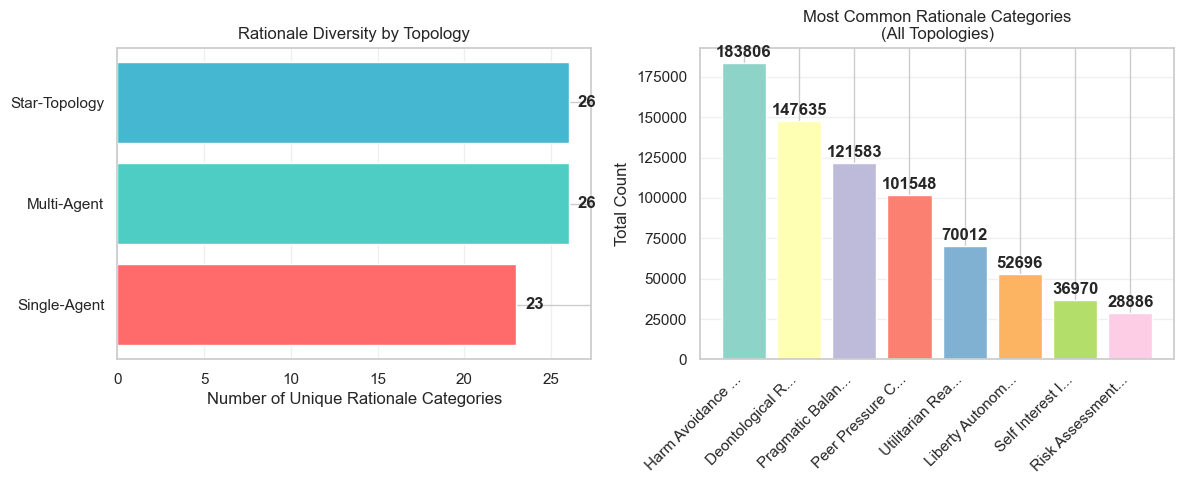

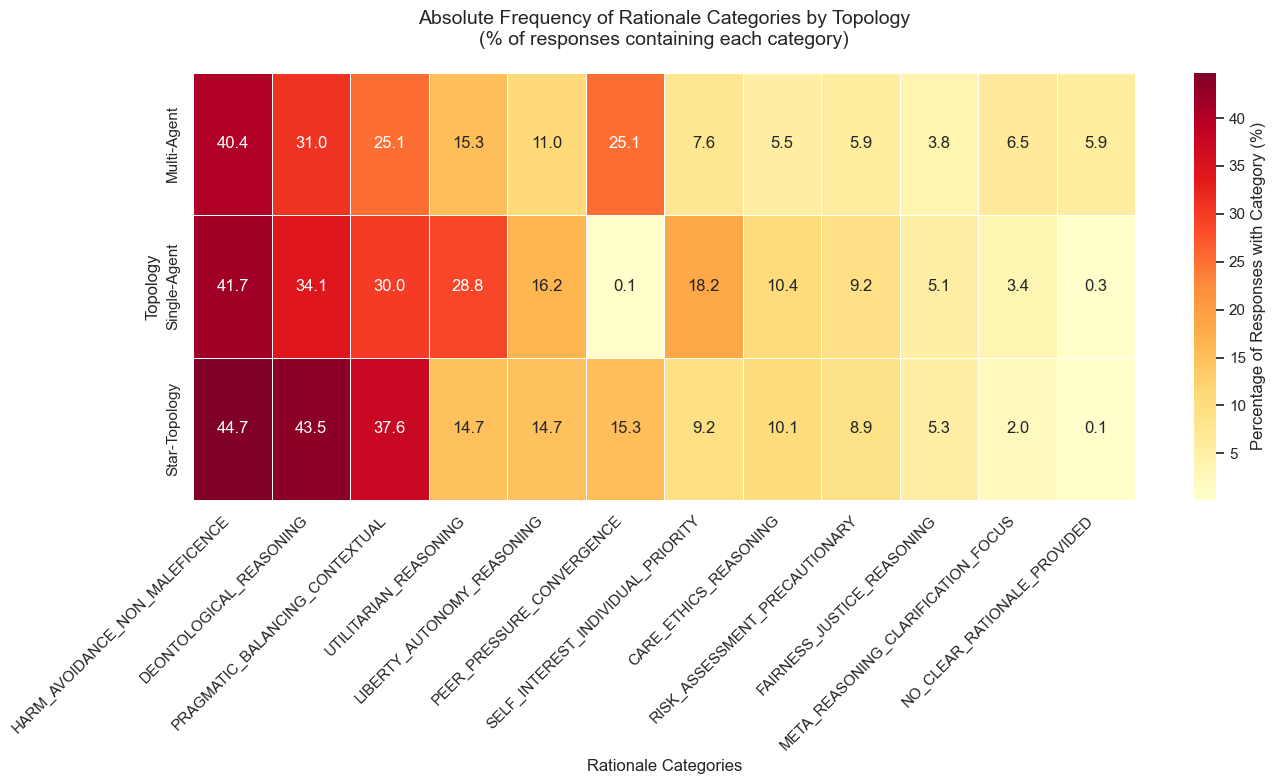

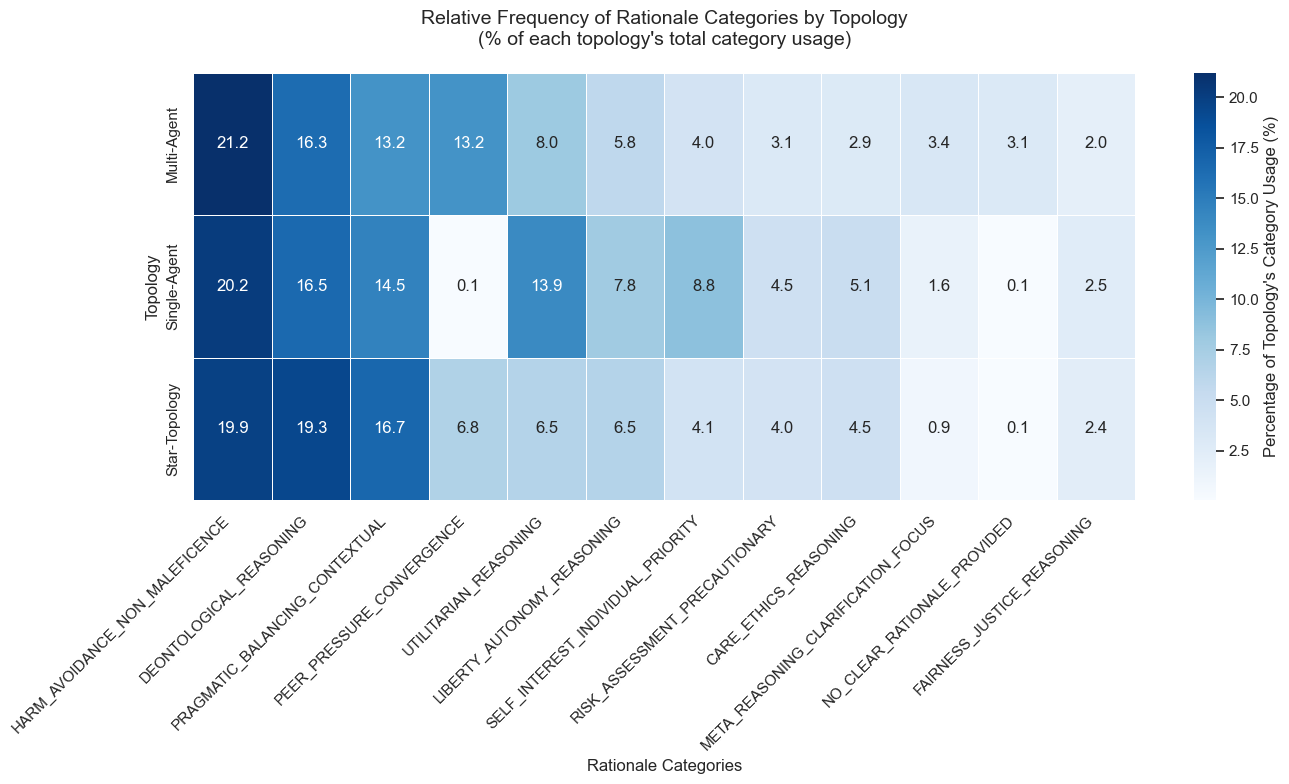


=== KEY INSIGHTS ===
1. Rationale Diversity:
   Single-Agent: 23 unique rationale types
   Multi-Agent: 26 unique rationale types
   Star-Topology: 26 unique rationale types

2. Most Common Overall: HARM_AVOIDANCE_NON_MALEFICENCE (183806 instances)

3. Topology-Specific Patterns (% of category instances):
   Multi-Agent: Most used = HARM_AVOIDANCE_NON_MALEFICENCE (21.2% of 689,620 total category instances)
   Single-Agent: Most used = HARM_AVOIDANCE_NON_MALEFICENCE (20.2% of 32,316 total category instances)
   Star-Topology: Most used = HARM_AVOIDANCE_NON_MALEFICENCE (19.9% of 155,039 total category instances)


In [30]:
# =============================================================================
# COMPARATIVE ANALYSIS CHARTS: ADVANCED TOPOLOGY COMPARISON
# =============================================================================
# Create sophisticated comparative visualizations to understand differences
# between agent topologies in terms of category diversity and usage patterns

if not exploded_df.empty:
    print("\n=== COMPARATIVE ANALYSIS ===")
    
    # =============================================================================
    # CHART 1: CATEGORY DIVERSITY BY TOPOLOGY
    # =============================================================================
    # Analyze how many unique rationale categories each topology uses
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    # Calculate unique category counts per topology and sort for better visualization
    diversity_data = exploded_df.groupby('topology')['selected_categories'].nunique().sort_values(ascending=True)
    bars = plt.barh(range(len(diversity_data)), diversity_data.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    plt.yticks(range(len(diversity_data)), diversity_data.index)
    plt.xlabel('Number of Unique Rationale Categories')
    plt.title('Rationale Diversity by Topology')
    plt.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars for exact counts
    for i, (bar, value) in enumerate(zip(bars, diversity_data.values)):
        plt.text(value + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{int(value)}', va='center', ha='left', fontweight='bold')
    
    # =============================================================================
    # CHART 2: MOST COMMON CATEGORIES ACROSS ALL TOPOLOGIES
    # =============================================================================
    # Show the overall top categories regardless of topology
    
    plt.subplot(1, 2, 2)
    top_overall = exploded_df['selected_categories'].value_counts().head(8)
    colors = plt.cm.Set3(range(len(top_overall)))
    bars = plt.bar(range(len(top_overall)), top_overall.values, color=colors)
    
    # Truncate long category names for display
    plt.xticks(range(len(top_overall)), 
               [cat.replace('_', ' ').title()[:15] + ('...' if len(cat) > 15 else '') 
                for cat in top_overall.index], 
               rotation=45, ha='right')
    plt.ylabel('Total Count')
    plt.title('Most Common Rationale Categories\n(All Topologies)')
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    max_overall = max(top_overall.values) if len(top_overall.values) > 0 else 1
    for bar, value in zip(bars, top_overall.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max_overall*0.01,
                f'{int(value)}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # =============================================================================
    # CHART 3: ABSOLUTE FREQUENCY PATTERNS (RESPONSE-BASED HEATMAP)
    # =============================================================================
    # Show category usage as absolute frequencies: (responses with category / total responses) * 100
    # This allows frequencies to sum to over 100% since responses can have multiple categories
    
    plt.figure(figsize=(14, 8))
    
    # Calculate absolute frequencies based on total responses per topology
    # Get the number of unique responses (not category instances) per topology
    topology_response_totals = combined_df.groupby('topology').size()  # Total responses per topology
    
    # Count how many responses contain each category per topology
    # First, get unique responses with each category
    response_cat_counts = []
    for topo in combined_df['topology'].unique():
        topo_data = combined_df[combined_df['topology'] == topo]
        for cat in valid_cats:
            # Count responses that contain this category
            responses_with_cat = topo_data[topo_data['selected_categories'].apply(
                lambda x: cat in x if isinstance(x, list) else False)].shape[0]
            if responses_with_cat > 0:  # Only include categories that appear
                response_cat_counts.append({
                    'topology': topo,
                    'selected_categories': cat,
                    'response_count': responses_with_cat
                })
    
    response_cat_df = pd.DataFrame(response_cat_counts)
    
    # Convert to absolute frequencies (percentage of responses containing each category)
    response_cat_df['absolute_freq'] = response_cat_df.apply(
        lambda row: (row['response_count'] / topology_response_totals[row['topology']]) * 100, axis=1)
    
    # Focus on top 12 categories for clarity
    top_12_cats = exploded_df['selected_categories'].value_counts().head(12).index.tolist()
    
    # Filter and create pivot table for heatmap
    filtered_data = response_cat_df[response_cat_df['selected_categories'].isin(top_12_cats)]
    absolute_pivot = filtered_data.pivot(
        index='topology', 
        columns='selected_categories', 
        values='absolute_freq'
    ).fillna(0)
    
    # Order columns by total usage across all topologies
    col_order = absolute_pivot.sum().sort_values(ascending=False).index
    absolute_pivot = absolute_pivot[col_order]
    
    # Create absolute frequency heatmap
    sns.heatmap(absolute_pivot, 
                annot=True,                                           # Show percentage values
                fmt='.1f',                                            # One decimal place
                cmap='YlOrRd',                                        # Yellow to red color scheme
                cbar_kws={'label': 'Percentage of Responses with Category (%)'},  # Updated color bar label
                linewidths=0.5)                                      # Grid lines
    
    plt.title('Absolute Frequency of Rationale Categories by Topology\n(% of responses containing each category)', 
              fontsize=14, pad=20)
    plt.xlabel('Rationale Categories', fontsize=12)
    plt.ylabel('Topology', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # =============================================================================
    # CHART 4: RELATIVE FREQUENCY PATTERNS (CATEGORY INSTANCE DISTRIBUTION)
    # =============================================================================
    # Create relative frequency pivot table that was missing
    # Show what percentage of category instances each topology contributes
    
    plt.figure(figsize=(14, 8))
    
    # Calculate relative frequencies: category instances per topology / total category instances
    topology_totals = exploded_df.groupby('topology')['selected_categories'].size()
    
    # Create pivot table with raw counts
    relative_counts = exploded_df.groupby(['topology', 'selected_categories']).size().reset_index(name='count')
    relative_pivot = relative_counts.pivot(
        index='topology', 
        columns='selected_categories', 
        values='count'
    ).fillna(0)
    
    # Convert to percentages of total category instances for each topology
    relative_pivot_pct = relative_pivot.div(relative_pivot.sum(axis=1), axis=0) * 100
    
    # Focus on top 12 categories
    available_top_cats = [cat for cat in top_12_cats if cat in relative_pivot_pct.columns]
    if available_top_cats:
        relative_pivot_pct = relative_pivot_pct[available_top_cats]
        
        # Create relative frequency heatmap
        sns.heatmap(relative_pivot_pct, 
                    annot=True,
                    fmt='.1f',
                    cmap='Blues',
                    cbar_kws={'label': 'Percentage of Topology\'s Category Usage (%)'},
                    linewidths=0.5)
        
        plt.title('Relative Frequency of Rationale Categories by Topology\n(% of each topology\'s total category usage)', 
                  fontsize=14, pad=20)
        plt.xlabel('Rationale Categories', fontsize=12)
        plt.ylabel('Topology', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    # =============================================================================
    # KEY INSIGHTS SUMMARY
    # =============================================================================
    # Provide quantitative insights from the comparative analysis
    
    print("\n=== KEY INSIGHTS ===")
    
    print("1. Rationale Diversity:")
    for topo, count in diversity_data.items():
        print(f"   {topo}: {count} unique rationale types")
    
    print(f"\n2. Most Common Overall: {top_overall.index[0]} ({top_overall.iloc[0]} instances)")
    
    print("\n3. Topology-Specific Patterns (% of category instances):")
    for topo in relative_pivot_pct.index:
        top_cat_for_topo = relative_pivot_pct.loc[topo].idxmax()
        top_freq = relative_pivot_pct.loc[topo].max()
        total_instances = topology_totals[topo]
        print(f"   {topo}: Most used = {top_cat_for_topo} ({top_freq:.1f}% of {total_instances:,} total category instances)")

else:
    print("No data available for comparative analysis.")


=== AGENT-SPECIFIC CATEGORY ANALYSIS ===

1. Single-Agent Category Usage by Model


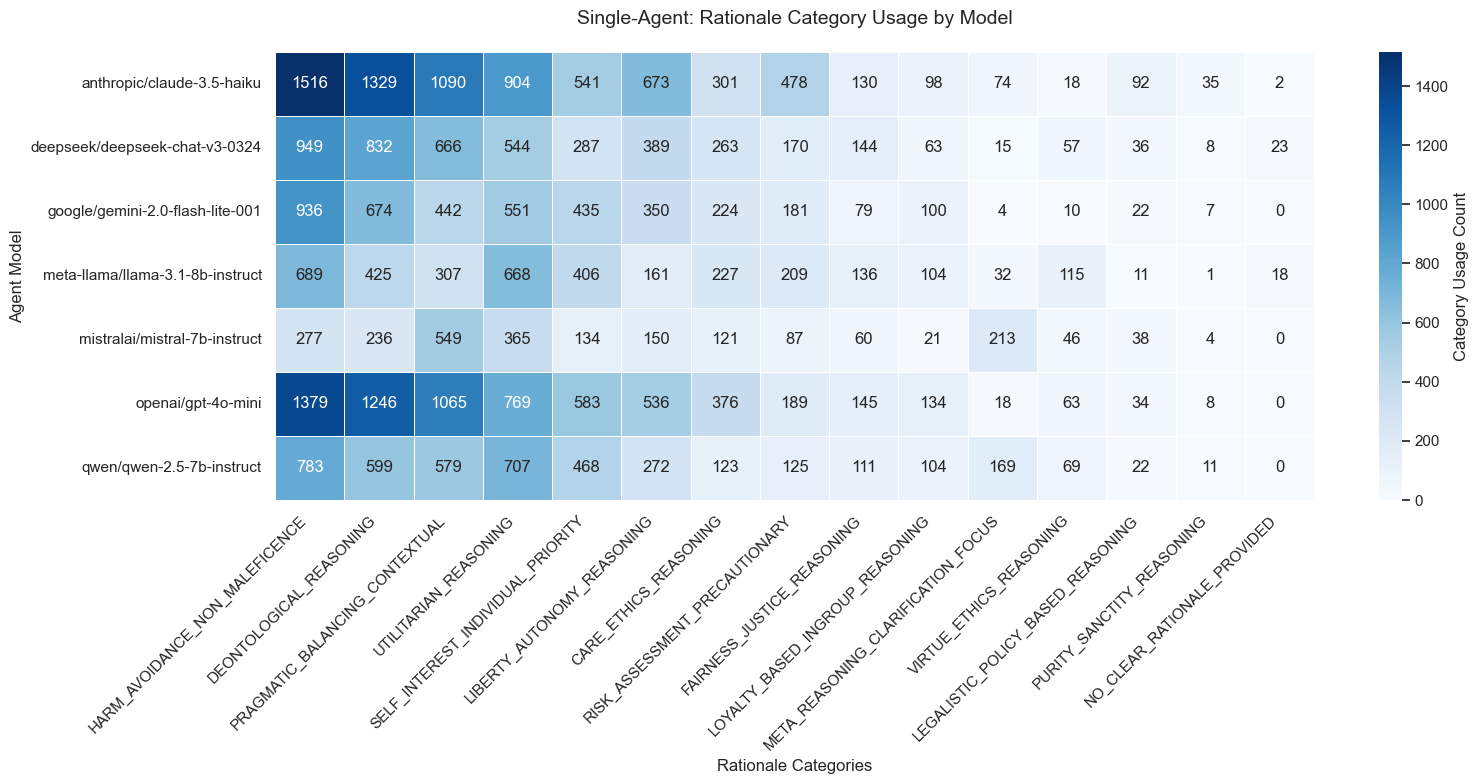


2. Multi-Agent Category Usage by Model


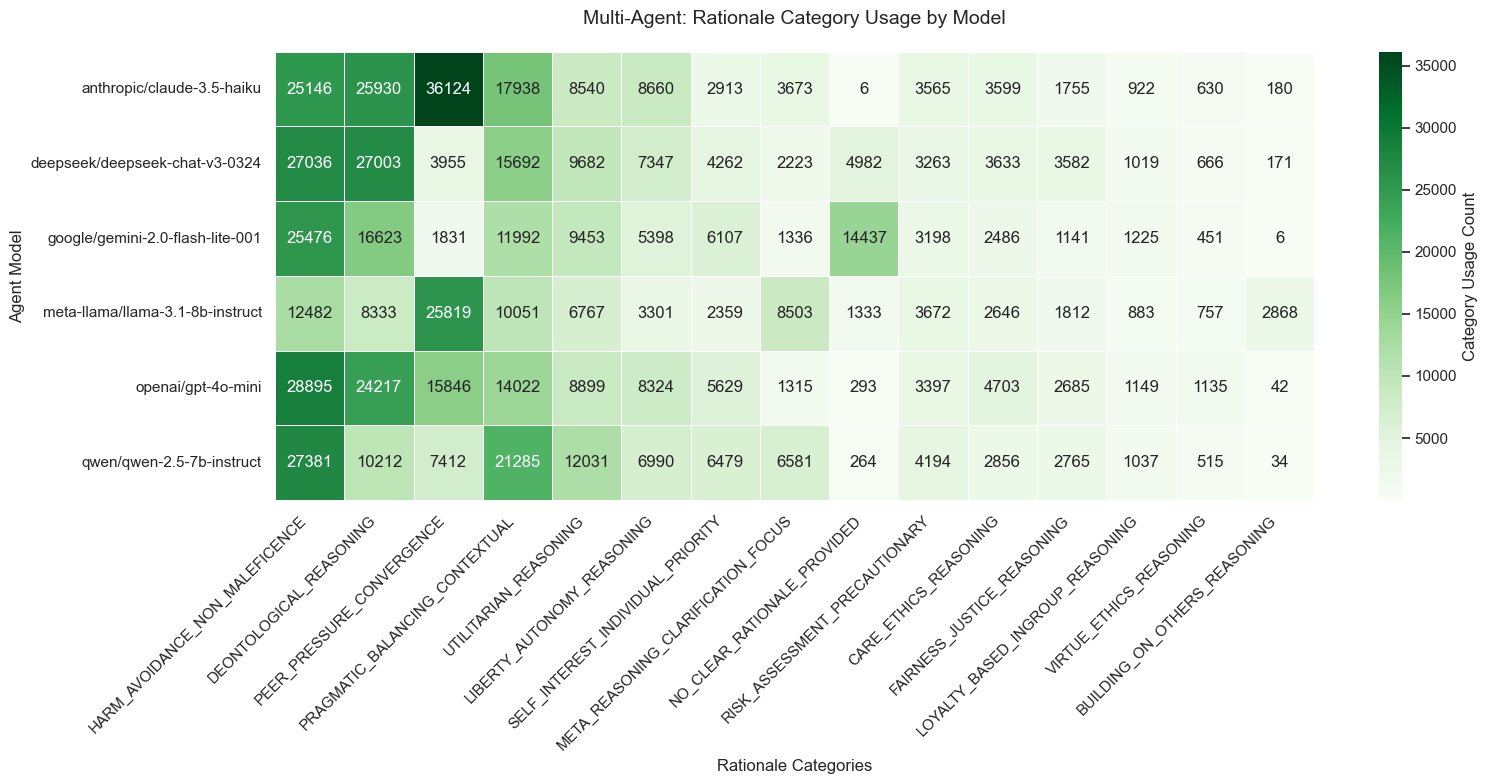


3. Star-Topology Category Usage by Model


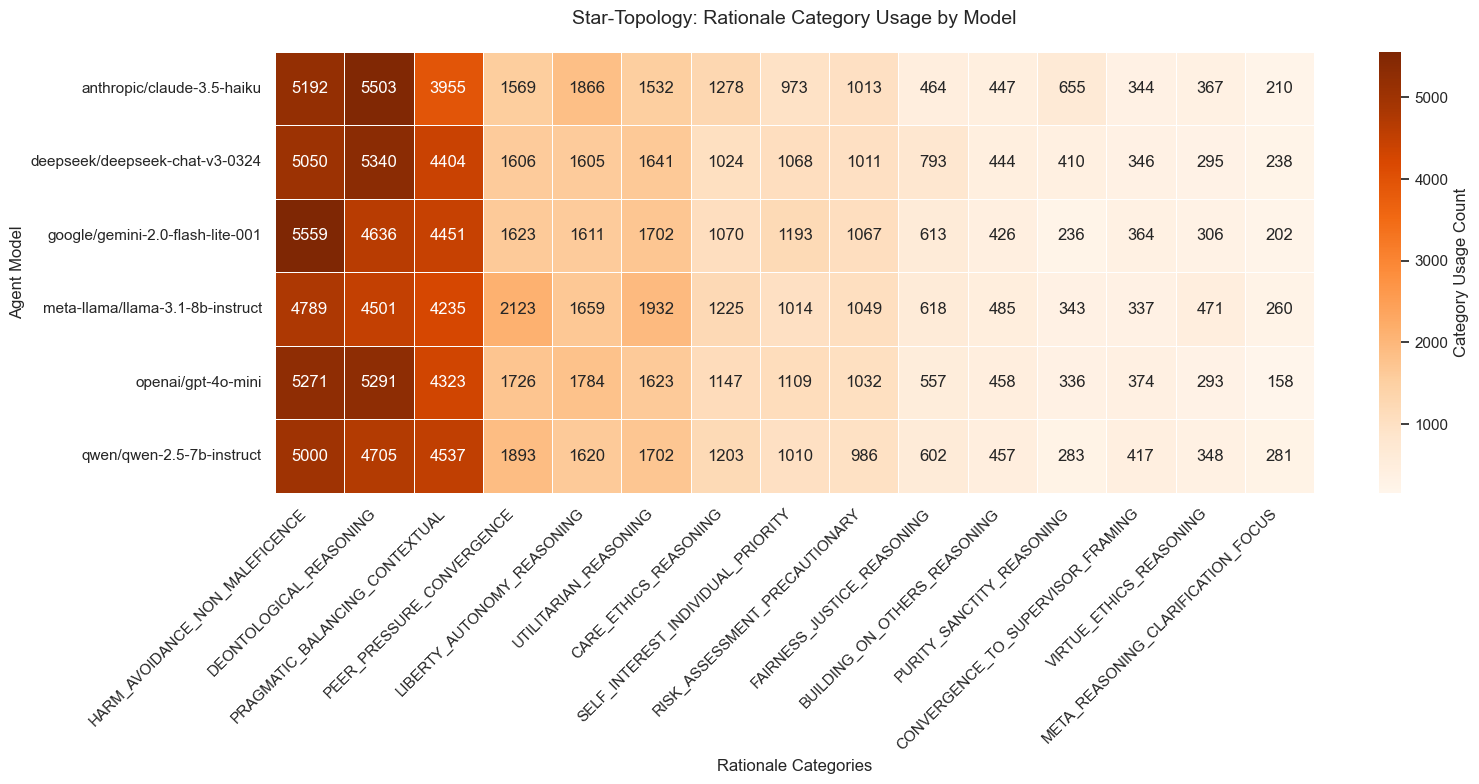


4. Cross-Topology Agent Model Comparison
Found 6 models appearing in multiple topologies: ['meta-llama/llama-3.1-8b-instruct', 'anthropic/claude-3.5-haiku', 'deepseek/deepseek-chat-v3-0324', 'openai/gpt-4o-mini', 'qwen/qwen-2.5-7b-instruct', 'google/gemini-2.0-flash-lite-001']

Top 5 categories for meta-llama/llama-3.1-8b-instruct:
  Single-Agent: HARM_AVOIDANCE_NON_MALEFICENCE (689), UTILITARIAN_REASONING (668), DEONTOLOGICAL_REASONING (425)
  Multi-Agent: PEER_PRESSURE_CONVERGENCE (25819), HARM_AVOIDANCE_NON_MALEFICENCE (12482), PRAGMATIC_BALANCING_CONTEXTUAL (10051)
  Star-Topology: HARM_AVOIDANCE_NON_MALEFICENCE (4789), DEONTOLOGICAL_REASONING (4501), PRAGMATIC_BALANCING_CONTEXTUAL (4235)
Found 6 models appearing in multiple topologies: ['meta-llama/llama-3.1-8b-instruct', 'anthropic/claude-3.5-haiku', 'deepseek/deepseek-chat-v3-0324', 'openai/gpt-4o-mini', 'qwen/qwen-2.5-7b-instruct', 'google/gemini-2.0-flash-lite-001']

Top 5 categories for meta-llama/llama-3.1-8b-instruct:
  Si

In [31]:
# =============================================================================
# AGENT-SPECIFIC HEATMAPS: ANALYZE CATEGORY USAGE BY INDIVIDUAL AGENTS
# =============================================================================
# Create heatmaps showing how different agent models use rationale categories
# within each topology type

if not exploded_df.empty and 'agent_model' in exploded_df.columns:
    print("\n=== AGENT-SPECIFIC CATEGORY ANALYSIS ===")
    
    # =============================================================================
    # HEATMAP 1: SINGLE-AGENT CATEGORY USAGE BY MODEL
    # =============================================================================
    single_agent_data = exploded_df[exploded_df['topology'] == 'Single-Agent']
    
    if not single_agent_data.empty:
        print("\n1. Single-Agent Category Usage by Model")
        
        # Get top 15 categories for single-agent
        top_15_single = single_agent_data['selected_categories'].value_counts().head(15).index.tolist()
        
        # Create agent-category count matrix
        single_agent_counts = single_agent_data.groupby(['agent_model', 'selected_categories']).size().reset_index(name='count')
        single_agent_pivot = single_agent_counts.pivot(
            index='agent_model', 
            columns='selected_categories', 
            values='count'
        ).fillna(0)
        
        # Filter to top categories
        available_single_cats = [cat for cat in top_15_single if cat in single_agent_pivot.columns]
        if available_single_cats:
            single_agent_pivot = single_agent_pivot[available_single_cats]
            
            plt.figure(figsize=(16, 8))
            sns.heatmap(single_agent_pivot, 
                       annot=True, 
                       fmt='g', 
                       cmap='Blues',
                       cbar_kws={'label': 'Category Usage Count'},
                       linewidths=0.5)
            plt.title('Single-Agent: Rationale Category Usage by Model', fontsize=14, pad=20)
            plt.xlabel('Rationale Categories', fontsize=12)
            plt.ylabel('Agent Model', fontsize=12)
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
    
    # =============================================================================
    # HEATMAP 2: MULTI-AGENT CATEGORY USAGE BY MODEL
    # =============================================================================
    multi_agent_data = exploded_df[exploded_df['topology'] == 'Multi-Agent']
    
    if not multi_agent_data.empty:
        print("\n2. Multi-Agent Category Usage by Model")
        
        # Get top 15 categories for multi-agent
        top_15_multi = multi_agent_data['selected_categories'].value_counts().head(15).index.tolist()
        
        # Create agent-category count matrix
        multi_agent_counts = multi_agent_data.groupby(['agent_model', 'selected_categories']).size().reset_index(name='count')
        multi_agent_pivot = multi_agent_counts.pivot(
            index='agent_model', 
            columns='selected_categories', 
            values='count'
        ).fillna(0)
        
        # Filter to top categories
        available_multi_cats = [cat for cat in top_15_multi if cat in multi_agent_pivot.columns]
        if available_multi_cats:
            multi_agent_pivot = multi_agent_pivot[available_multi_cats]
            
            plt.figure(figsize=(16, 8))
            sns.heatmap(multi_agent_pivot, 
                       annot=True, 
                       fmt='g', 
                       cmap='Greens',
                       cbar_kws={'label': 'Category Usage Count'},
                       linewidths=0.5)
            plt.title('Multi-Agent: Rationale Category Usage by Model', fontsize=14, pad=20)
            plt.xlabel('Rationale Categories', fontsize=12)
            plt.ylabel('Agent Model', fontsize=12)
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
    
    # =============================================================================
    # HEATMAP 3: STAR TOPOLOGY CATEGORY USAGE BY MODEL
    # =============================================================================
    star_data = exploded_df[exploded_df['topology'] == 'Star-Topology']
    
    if not star_data.empty:
        print("\n3. Star-Topology Category Usage by Model")
        
        # Get top 15 categories for star topology
        top_15_star = star_data['selected_categories'].value_counts().head(15).index.tolist()
        
        # Create agent-category count matrix
        star_counts = star_data.groupby(['agent_model', 'selected_categories']).size().reset_index(name='count')
        star_pivot = star_counts.pivot(
            index='agent_model', 
            columns='selected_categories', 
            values='count'
        ).fillna(0)
        
        # Filter to top categories
        available_star_cats = [cat for cat in top_15_star if cat in star_pivot.columns]
        if available_star_cats:
            star_pivot = star_pivot[available_star_cats]
            
            plt.figure(figsize=(16, 8))
            sns.heatmap(star_pivot, 
                       annot=True, 
                       fmt='g', 
                       cmap='Oranges',
                       cbar_kws={'label': 'Category Usage Count'},
                       linewidths=0.5)
            plt.title('Star-Topology: Rationale Category Usage by Model', fontsize=14, pad=20)
            plt.xlabel('Rationale Categories', fontsize=12)
            plt.ylabel('Agent Model', fontsize=12)
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
    
    # =============================================================================
    # COMPARATIVE AGENT PERFORMANCE ACROSS TOPOLOGIES
    # =============================================================================
    print("\n4. Cross-Topology Agent Model Comparison")
    
    # Find models that appear in multiple topologies
    models_by_topology = exploded_df.groupby('topology')['agent_model'].unique()
    
    # Find common models across topologies
    all_models = set()
    for models_list in models_by_topology:
        all_models.update(models_list)
    
    common_models = []
    for model in all_models:
        topology_count = sum(1 for topology_models in models_by_topology if model in topology_models)
        if topology_count > 1:  # Model appears in multiple topologies
            common_models.append(model)
    
    if common_models:
        print(f"Found {len(common_models)} models appearing in multiple topologies: {common_models}")
        
        # Create a summary comparison
        for model in common_models:
            model_data = exploded_df[exploded_df['agent_model'] == model]
            model_by_topology = model_data.groupby('topology')['selected_categories'].value_counts().head(5)
            
            print(f"\nTop 5 categories for {model}:")
            for topology in model_data['topology'].unique():
                topo_data = model_data[model_data['topology'] == topology]
                top_cats = topo_data['selected_categories'].value_counts().head(3)
                print(f"  {topology}: {', '.join([f'{cat} ({count})' for cat, count in top_cats.items()])}")

else:
    print("No agent model data available for agent-specific analysis.")

In [32]:
# =============================================================================
# QUESTION CATEGORY HEATMAPS: ANALYZE RATIONALE USAGE BY QUESTION TYPE
# =============================================================================
# Create heatmaps showing how rationale categories vary by question category
# across different topologies

if not exploded_df.empty and 'category' in exploded_df.columns:
    print("\n=== QUESTION CATEGORY ANALYSIS ===")
    
    # Get unique question categories
    question_cats = exploded_df['category'].dropna().unique()
    
    if len(question_cats) > 1:
        print(f"Found {len(question_cats)} question categories: {list(question_cats)}")
        
        # =============================================================================
        # HEATMAP 1: RATIONALE CATEGORIES BY QUESTION CATEGORY (ALL TOPOLOGIES)
        # =============================================================================
        print("\n1. Overall Rationale Usage by Question Category")
        
        # Get top 12 rationale categories overall
        top_12_rationale = exploded_df['selected_categories'].value_counts().head(12).index.tolist()
        
        # Create question category vs rationale category matrix
        question_rationale_counts = exploded_df.groupby(['category', 'selected_categories']).size().reset_index(name='count')
        question_rationale_pivot = question_rationale_counts.pivot(
            index='category', 
            columns='selected_categories', 
            values='count'
        ).fillna(0)
        
        # Filter to top rationale categories
        available_rationale_cats = [cat for cat in top_12_rationale if cat in question_rationale_pivot.columns]
        if available_rationale_cats:
            question_rationale_pivot = question_rationale_pivot[available_rationale_cats]
            
            plt.figure(figsize=(14, 6))
            sns.heatmap(question_rationale_pivot, 
                       annot=True, 
                       fmt='g', 
                       cmap='viridis',
                       cbar_kws={'label': 'Usage Count'},
                       linewidths=0.5)
            plt.title('Rationale Category Usage by Question Category (All Topologies)', fontsize=14, pad=20)
            plt.xlabel('Rationale Categories', fontsize=12)
            plt.ylabel('Question Categories', fontsize=12)
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
        
        # =============================================================================
        # HEATMAP 2: QUESTION CATEGORY VS TOPOLOGY INTERACTION
        # =============================================================================
        print("\n2. Question Category Distribution Across Topologies")
        
        # Create question category vs topology matrix
        question_topology_counts = exploded_df.groupby(['category', 'topology']).size().reset_index(name='count')
        question_topology_pivot = question_topology_counts.pivot(
            index='category', 
            columns='topology', 
            values='count'
        ).fillna(0)
        
        plt.figure(figsize=(10, 6))
        sns.heatmap(question_topology_pivot, 
                   annot=True, 
                   fmt='g', 
                   cmap='plasma',
                   cbar_kws={'label': 'Response Count'},
                   linewidths=0.5)
        plt.title('Question Category Distribution Across Topologies', fontsize=14, pad=20)
        plt.xlabel('Topology', fontsize=12)
        plt.ylabel('Question Categories', fontsize=12)
        plt.xticks(rotation=0)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        # =============================================================================
        # HEATMAP 3: DETAILED BREAKDOWN BY QUESTION CATEGORY AND TOPOLOGY
        # =============================================================================
        print("\n3. Detailed Rationale Usage by Question Category and Topology")
        
        # Create separate heatmaps for each question category
        n_question_cats = len(question_cats)
        cols = min(2, n_question_cats)
        rows = (n_question_cats + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(12 * cols, 6 * rows))
        if n_question_cats == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes.reshape(1, -1)
        
        fig.suptitle('Top Rationale Categories by Question Category and Topology', fontsize=16, y=1.02)
        
        for idx, q_cat in enumerate(question_cats):
            row = idx // cols
            col = idx % cols
            ax = axes[row, col] if rows > 1 else axes[col]
            
            # Filter data for this question category
            q_cat_data = exploded_df[exploded_df['category'] == q_cat]
            
            if not q_cat_data.empty:
                # Get top 8 rationale categories for this question type
                top_8_for_qcat = q_cat_data['selected_categories'].value_counts().head(8).index.tolist()
                
                # Create topology vs rationale category matrix for this question category
                qcat_topo_rationale = q_cat_data.groupby(['topology', 'selected_categories']).size().reset_index(name='count')
                qcat_pivot = qcat_topo_rationale.pivot(
                    index='topology', 
                    columns='selected_categories', 
                    values='count'
                ).fillna(0)
                
                # Filter to top categories for this question type
                available_qcat_rationale = [cat for cat in top_8_for_qcat if cat in qcat_pivot.columns]
                if available_qcat_rationale:
                    qcat_pivot = qcat_pivot[available_qcat_rationale]
                    
                    sns.heatmap(qcat_pivot, 
                               annot=True, 
                               fmt='g', 
                               cmap='coolwarm',
                               ax=ax,
                               cbar=True,
                               linewidths=0.5)
                    ax.set_title(f'{q_cat}', fontsize=12, fontweight='bold')
                    ax.set_xlabel('Rationale Category', fontsize=10)
                    ax.set_ylabel('Topology', fontsize=10)
                    ax.tick_params(axis='x', rotation=45, labelsize=8)
                    ax.tick_params(axis='y', rotation=0, labelsize=9)
                else:
                    ax.text(0.5, 0.5, f'No Data\n{q_cat}', ha='center', va='center', 
                           transform=ax.transAxes, fontsize=12)
                    ax.set_title(f'{q_cat}', fontsize=12, fontweight='bold')
            else:
                ax.text(0.5, 0.5, f'No Data\n{q_cat}', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=12)
                ax.set_title(f'{q_cat}', fontsize=12, fontweight='bold')
        
        # Hide extra subplots
        for idx in range(n_question_cats, rows * cols):
            row = idx // cols
            col = idx % cols
            ax = axes[row, col] if rows > 1 else axes[col]
            ax.set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        # =============================================================================
        # SUMMARY STATISTICS BY QUESTION CATEGORY
        # =============================================================================
        print("\n=== QUESTION CATEGORY SUMMARY STATISTICS ===")
        
        for q_cat in question_cats:
            q_data = exploded_df[exploded_df['category'] == q_cat]
            if not q_data.empty:
                total_responses = len(q_data)
                unique_rationales = q_data['selected_categories'].nunique()
                top_rationale = q_data['selected_categories'].mode().iloc[0] if len(q_data) > 0 else "None"
                
                print(f"\n{q_cat}:")
                print(f"  Total rationale instances: {total_responses:,}")
                print(f"  Unique rationale types: {unique_rationales}")
                print(f"  Most common rationale: {top_rationale}")
                
                # Distribution across topologies
                topo_dist = q_data['topology'].value_counts()
                print(f"  Topology distribution: {dict(topo_dist)}")
                
                # Top 3 rationale categories for this question type
                top_3_rationales = q_data['selected_categories'].value_counts().head(3)
                print(f"  Top 3 rationales: {', '.join([f'{cat} ({count})' for cat, count in top_3_rationales.items()])}")
    
    else:
        print(f"Only one question category found: {question_cats[0] if question_cats else 'None'}")
        print("Skipping question category analysis.")

elif 'category' not in exploded_df.columns:
    print("No question category data available in the dataset.")
else:
    print("No data available for question category analysis.")

No question category data available in the dataset.


In [ ]:
# =============================================================================
# CATEGORY SPLITS ANALYSIS: IH/IB AND MODEL TYPE BREAKDOWNS
# =============================================================================
# Create detailed heatmaps split by question categories (IH/IB) and model types
# for comprehensive analysis of how different experimental conditions affect reasoning

if not exploded_df.empty and 'category' in exploded_df.columns:
    print("\n=== CATEGORY SPLITS ANALYSIS ===")
    
    # Get unique question categories
    question_categories = exploded_df['category'].dropna().unique()
    print(f"Found question categories: {list(question_categories)}")
    
    # =============================================================================
    # PLOTS 1-2: IH vs IB QUESTION CATEGORY HEATMAPS BY TOPOLOGY
    # =============================================================================
    # Create separate heatmaps for each question category across all topologies
    
    for q_category in question_categories:
        if q_category in ['IH', 'IB']:  # Focus on the main categories
            print(f"\n{q_category} Question Category Analysis")
            
            # Filter data for this question category
            category_data = exploded_df[exploded_df['category'] == q_category]
            
            if not category_data.empty:
                # Get top 15 rationale categories for this question type
                top_15_rationale = category_data['selected_categories'].value_counts().head(15).index.tolist()
                
                # Create topology vs rationale category matrix
                category_topo_counts = category_data.groupby(['topology', 'selected_categories']).size().reset_index(name='count')
                category_pivot = category_topo_counts.pivot(
                    index='topology', 
                    columns='selected_categories', 
                    values='count'
                ).fillna(0)
                
                # Filter to top categories for this question type
                available_rationale_cats = [cat for cat in top_15_rationale if cat in category_pivot.columns]
                if available_rationale_cats:
                    category_pivot = category_pivot[available_rationale_cats]
                    
                    plt.figure(figsize=(18, 8))
                    sns.heatmap(category_pivot, 
                               annot=True, 
                               fmt='g', 
                               cmap='RdYlBu_r',
                               cbar_kws={'label': 'Usage Count'},
                               linewidths=0.5)
                    plt.title(f'{q_category} Questions: Rationale Category Usage by Topology', fontsize=16, pad=20)
                    plt.xlabel('Rationale Categories', fontsize=12)
                    plt.ylabel('Topology', fontsize=12)
                    plt.xticks(rotation=45, ha='right')
                    plt.yticks(rotation=0)
                    plt.tight_layout()
                    plt.show()
                    
                    # Print summary statistics for this category
                    total_responses = len(category_data)
                    unique_rationales = category_data['selected_categories'].nunique()
                    top_rationale = category_data['selected_categories'].mode().iloc[0] if len(category_data) > 0 else "None"
                    
                    print(f"{q_category} Summary:")
                    print(f"  Total rationale instances: {total_responses:,}")
                    print(f"  Unique rationale types: {unique_rationales}")
                    print(f"  Most common rationale: {top_rationale}")
                    
                    # Topology distribution for this category
                    topo_dist = category_data['topology'].value_counts()
                    print(f"  Topology distribution: {dict(topo_dist)}")
    
    # =============================================================================
    # PLOTS 3-4: INVERTED vs NON-INVERTED ANALYSIS (if data available)
    # =============================================================================
    # Check if we have inverted data indicators in the dataset
    
    # Look for indicators of inverted questions in question IDs or other fields
    inverted_indicators = []
    if 'question_id' in exploded_df.columns:
        # Check if question IDs indicate inverted versions (common patterns)
        question_ids = exploded_df['question_id'].unique()
        
        # Look for patterns that might indicate inverted questions
        # This is dataset-specific - adjust based on actual data structure
        regular_questions = []
        inverted_questions = []
        
        for qid in question_ids:
            qid_str = str(qid)
            # Common patterns for inverted questions (adjust as needed)
            if any(indicator in qid_str.lower() for indicator in ['inv', 'inverted', '_i', 'reverse']):
                inverted_questions.append(qid)
            else:
                regular_questions.append(qid)
        
        if len(inverted_questions) > 0:
            print(f"\nFound {len(inverted_questions)} potentially inverted questions and {len(regular_questions)} regular questions")
            
            # Create inverted vs non-inverted comparison
            for inversion_type, question_list in [('Non-Inverted', regular_questions), ('Inverted', inverted_questions)]:
                if question_list:
                    print(f"\n{inversion_type} Questions Analysis")
                    
                    # Filter data for this inversion type
                    inversion_data = exploded_df[exploded_df['question_id'].isin(question_list)]
                    
                    if not inversion_data.empty:
                        # Get top 12 rationale categories for this inversion type
                        top_12_rationale = inversion_data['selected_categories'].value_counts().head(12).index.tolist()
                        
                        # Create topology vs rationale category matrix
                        inversion_topo_counts = inversion_data.groupby(['topology', 'selected_categories']).size().reset_index(name='count')
                        inversion_pivot = inversion_topo_counts.pivot(
                            index='topology', 
                            columns='selected_categories', 
                            values='count'
                        ).fillna(0)
                        
                        # Filter to top categories
                        available_rationale_cats = [cat for cat in top_12_rationale if cat in inversion_pivot.columns]
                        if available_rationale_cats:
                            inversion_pivot = inversion_pivot[available_rationale_cats]
                            
                            plt.figure(figsize=(16, 8))
                            sns.heatmap(inversion_pivot, 
                                       annot=True, 
                                       fmt='g', 
                                       cmap='plasma',
                                       cbar_kws={'label': 'Usage Count'},
                                       linewidths=0.5)
                            plt.title(f'{inversion_type} Questions: Rationale Category Usage by Topology', fontsize=16, pad=20)
                            plt.xlabel('Rationale Categories', fontsize=12)
                            plt.ylabel('Topology', fontsize=12)
                            plt.xticks(rotation=45, ha='right')
                            plt.yticks(rotation=0)
                            plt.tight_layout()
                            plt.show()
        else:
            print("\nNo inverted question patterns detected in the dataset")
    
    # =============================================================================
    # PLOTS 5-10: MODEL TYPE SPLITS FOR SINGLE AGENT AND HOMOGENEOUS RING
    # =============================================================================
    # Create detailed model type analysis for single agents and identify homogeneous configurations
    
    print("\n=== MODEL TYPE SPLITS ANALYSIS ===")
    
    # Single Agent Model Type Analysis
    single_agent_data = exploded_df[exploded_df['topology'] == 'Single-Agent']
    
    if not single_agent_data.empty and 'agent_model' in single_agent_data.columns:
        print("\nSingle Agent Model Type Analysis")
        
        # Group models by type/family
        model_families = {
            'OpenAI': ['openai/gpt-4o-mini', 'openai/gpt-4o', 'openai/gpt-3.5-turbo'],
            'Anthropic': ['anthropic/claude-3.5-haiku', 'anthropic/claude-3.5-sonnet', 'anthropic/claude-3-haiku'],
            'Google': ['google/gemini-2.0-flash-lite-001', 'google/gemini-pro', 'google/gemini-1.5-pro'],
            'Meta': ['meta-llama/llama-3.1-8b-instruct', 'meta-llama/llama-2-70b-chat'],
            'Qwen': ['qwen/qwen-2.5-7b-instruct', 'qwen/qwen-72b-chat'],
            'DeepSeek': ['deepseek/deepseek-chat-v3-0324', 'deepseek/deepseek-coder'],
            'Mistral': ['mistralai/mistral-7b-instruct', 'mistralai/mixtral-8x7b-instruct']
        }
        
        # Add model family column
        def get_model_family(model_name):
            for family, models in model_families.items():
                if any(model in str(model_name) for model in models):
                    return family
            return 'Other'
        
        single_agent_data = single_agent_data.copy()
        single_agent_data['model_family'] = single_agent_data['agent_model'].apply(get_model_family)
        
        # Get unique model families in the data
        available_families = single_agent_data['model_family'].unique()
        print(f"Found model families in single-agent data: {list(available_families)}")
        
        # Create heatmaps for each model family
        for family in available_families:
            if family != 'Other':  # Skip 'Other' category for cleaner analysis
                family_data = single_agent_data[single_agent_data['model_family'] == family]
                
                if not family_data.empty:
                    print(f"\n{family} Model Family Analysis")
                    
                    # Get top 12 rationale categories for this model family
                    top_12_rationale = family_data['selected_categories'].value_counts().head(12).index.tolist()
                    
                    # Create model vs rationale category matrix
                    family_model_counts = family_data.groupby(['agent_model', 'selected_categories']).size().reset_index(name='count')
                    family_pivot = family_model_counts.pivot(
                        index='agent_model', 
                        columns='selected_categories', 
                        values='count'
                    ).fillna(0)
                    
                    # Filter to top categories
                    available_rationale_cats = [cat for cat in top_12_rationale if cat in family_pivot.columns]
                    if available_rationale_cats and len(family_pivot) > 0:
                        family_pivot = family_pivot[available_rationale_cats]
                        
                        plt.figure(figsize=(16, 6))
                        sns.heatmap(family_pivot, 
                                   annot=True, 
                                   fmt='g', 
                                   cmap='viridis',
                                   cbar_kws={'label': 'Usage Count'},
                                   linewidths=0.5)
                        plt.title(f'Single Agent - {family} Models: Rationale Category Usage', fontsize=14, pad=20)
                        plt.xlabel('Rationale Categories', fontsize=12)
                        plt.ylabel('Model', fontsize=12)
                        plt.xticks(rotation=45, ha='right')
                        plt.yticks(rotation=0)
                        plt.tight_layout()
                        plt.show()
                        
                        # Print summary for this family
                        family_total = len(family_data)
                        family_models = family_data['agent_model'].nunique()
                        family_top_rationale = family_data['selected_categories'].mode().iloc[0] if len(family_data) > 0 else "None"
                        
                        print(f"  Total responses: {family_total:,}")
                        print(f"  Models in family: {family_models}")
                        print(f"  Top rationale: {family_top_rationale}")
    
    # =============================================================================
    # HOMOGENEOUS RING ANALYSIS
    # =============================================================================
    # Identify and analyze homogeneous configurations in multi-agent data
    
    multi_agent_data = exploded_df[exploded_df['topology'] == 'Multi-Agent']
    
    if not multi_agent_data.empty and 'agent_model' in multi_agent_data.columns:
        print("\nHomogeneous Ring Configuration Analysis")
        
        # Group by question/conversation to identify homogeneous setups
        # For each question, check if all agents use the same model
        if 'question_id' in multi_agent_data.columns:
            conversation_models = multi_agent_data.groupby('question_id')['agent_model'].nunique()
            homogeneous_conversations = conversation_models[conversation_models == 1].index
            
            if len(homogeneous_conversations) > 0:
                print(f"Found {len(homogeneous_conversations)} homogeneous conversations out of {len(conversation_models)} total")
                
                # Filter to homogeneous conversations
                homogeneous_data = multi_agent_data[multi_agent_data['question_id'].isin(homogeneous_conversations)]
                
                # Add model family for homogeneous analysis
                homogeneous_data = homogeneous_data.copy()
                homogeneous_data['model_family'] = homogeneous_data['agent_model'].apply(get_model_family)
                
                # Group homogeneous conversations by model family
                for family in homogeneous_data['model_family'].unique():
                    if family != 'Other':
                        family_homo_data = homogeneous_data[homogeneous_data['model_family'] == family]
                        
                        if not family_homo_data.empty:
                            print(f"\nHomogeneous {family} Ring Analysis")
                            
                            # Get top 12 rationale categories for this homogeneous family
                            top_12_rationale = family_homo_data['selected_categories'].value_counts().head(12).index.tolist()
                            
                            # Create model vs rationale category matrix for homogeneous rings
                            homo_model_counts = family_homo_data.groupby(['agent_model', 'selected_categories']).size().reset_index(name='count')
                            homo_pivot = homo_model_counts.pivot(
                                index='agent_model', 
                                columns='selected_categories', 
                                values='count'
                            ).fillna(0)
                            
                            # Filter to top categories
                            available_rationale_cats = [cat for cat in top_12_rationale if cat in homo_pivot.columns]
                            if available_rationale_cats and len(homo_pivot) > 0:
                                homo_pivot = homo_pivot[available_rationale_cats]
                                
                                plt.figure(figsize=(16, 6))
                                sns.heatmap(homo_pivot, 
                                           annot=True, 
                                           fmt='g', 
                                           cmap='coolwarm',
                                           cbar_kws={'label': 'Usage Count'},
                                           linewidths=0.5)
                                plt.title(f'Homogeneous Ring - {family} Models: Rationale Category Usage', fontsize=14, pad=20)
                                plt.xlabel('Rationale Categories', fontsize=12)
                                plt.ylabel('Model', fontsize=12)
                                plt.xticks(rotation=45, ha='right')
                                plt.yticks(rotation=0)
                                plt.tight_layout()
                                plt.show()
                                
                                # Print summary for this homogeneous family
                                homo_total = len(family_homo_data)
                                homo_conversations = family_homo_data['question_id'].nunique()
                                homo_top_rationale = family_homo_data['selected_categories'].mode().iloc[0] if len(family_homo_data) > 0 else "None"
                                
                                print(f"  Total responses in homogeneous rings: {homo_total:,}")
                                print(f"  Homogeneous conversations: {homo_conversations}")
                                print(f"  Top rationale: {homo_top_rationale}")
            else:
                print("No homogeneous ring configurations found in multi-agent data")
    
    # =============================================================================
    # COMPARATIVE SUMMARY ACROSS ALL SPLITS
    # =============================================================================
    print("\n=== SPLIT ANALYSIS SUMMARY ===")
    
    # Summary statistics for different splits
    split_summaries = []
    
    # Question category splits
    for q_cat in question_categories:
        if q_cat in ['IH', 'IB']:
            cat_data = exploded_df[exploded_df['category'] == q_cat]
            if not cat_data.empty:
                split_summaries.append({
                    'Split Type': 'Question Category',
                    'Split Name': q_cat,
                    'Total Responses': len(cat_data),
                    'Unique Rationales': cat_data['selected_categories'].nunique(),
                    'Top Rationale': cat_data['selected_categories'].mode().iloc[0] if len(cat_data) > 0 else "None",
                    'Topologies': ', '.join(cat_data['topology'].unique())
                })
    
    # Model family splits (single agent)
    if not single_agent_data.empty:
        for family in available_families:
            if family != 'Other':
                family_data = single_agent_data[single_agent_data['model_family'] == family]
                if not family_data.empty:
                    split_summaries.append({
                        'Split Type': 'Single Agent Family',
                        'Split Name': family,
                        'Total Responses': len(family_data),
                        'Unique Rationales': family_data['selected_categories'].nunique(),
                        'Top Rationale': family_data['selected_categories'].mode().iloc[0] if len(family_data) > 0 else "None",
                        'Topologies': 'Single-Agent'
                    })
    
    if split_summaries:
        splits_df = pd.DataFrame(split_summaries)
        print("\nSplit Analysis Summary Table:")
        print(splits_df.to_string(index=False))
    
else:
    print("No category data available for split analysis.")